In [1]:
import os
import json
import random
import time
import copy
import math

import numpy as np
from matplotlib import pyplot as plt
import cv2

from numba import jit,njit

from sklearn.metrics.pairwise import haversine_distances,euclidean_distances
from sklearn.cluster import DBSCAN
from scipy import spatial
from shapely import geometry
from fuzzywuzzy import fuzz

# set matpltolib style for the plots
plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

# Print numbers fully instead of scientific notation 
np.set_printoptions(suppress=True)

### Some helper functions

In [2]:
def get_center(line):
    """
    Return the center coordinate of the text bounding box
    """
    bbox = np.array(line['boundingBox'],dtype=np.int32).reshape((4,2))
    return np.mean(bbox,axis=0)

    
def take_best(line):
    """
    For vertival text, we have 2 geolocation and text possibilities, this function will return the possibility
    with the best match between the text and geolocations
    """
    geo1 = line['geolocation']
    geo2 = line['geolocation2']
    empty1 = len(geo1) == 0
    empty2 = len(geo2) == 0
    text1,text2 = line['text'].split('|')
    if empty1 and empty2:
        return None
    elif empty1:
        line['geolocation'] = geo2
        line['text'] = text2
    elif empty2:
        line['geolocation'] = geo1
        line['text'] = text1
    else:
        if geo1[0][1] >= geo2[0][1]:
            line['geolocation'] = geo1
            line['text'] = text1
        else:
            line['geolocation'] = geo2
            line['text'] = text2
            
    del line['geolocation2']
    return line


def iou(a, b):
    return a.intersection(b).area / a.union(b).area


def fraction_inside(a,b):
    area_b = b.area
    if area_b == 0:
        return None
    
    return a.intersection(b).area / b.area


def remove_duplicate_geolocations(geo):
    """
    Remove duplicate geolocations with same name and type if they lie close to each other
    """
    placename_types = {'country','political','locality','administrative_area','sublocality','sublocality_level_1','geography'}
    road_types = {'street','road','route'}
    
    for g_ in geo:
        g = g_[0]
        if 'type' in g:
            typ = g['type']
            types = typ.lower().split(',')
            found=False
            for t in types:
                if t in placename_types:
                    g['type'] = 'locality'
                    break
                elif t in road_types:
                    g['type'] = 'street'
                    break
    
    res = []
    found_names = {}
    # lat,lng
    found_coords = np.array([[0,0]],dtype=np.float32)
    delta_street = 0.01
    delta_locality = 0.1
    for g_ in geo:
        g = g_[0]
        if 'type' in g:
            typ = g['type']
            name = g['name'].lower()
            lat = g['lat']
            lng = g['lng']
            c1 = np.array([lat,lng],dtype=np.float32)
            
            if name in found_names:
                found_types = found_names[name]
                # check if it is close
                if typ in found_types:
                   
                    dlat =np.min(np.abs(c1[0]-found_coords[:,0]))
                    dlng =np.min(np.abs(c1[1]-found_coords[:,1]))
                    
                    
                    delta = delta_locality if typ == 'locality' else delta_street
                    
                    if dlat > delta and dlng > delta:
                        res.append(g_)
                        found_coords = np.append(found_coords,[c1],axis=0)
                    
                else:
                    found_types.add(typ)
                    res.append(g_)
                    found_coords = np.append(found_coords,[c1],axis=0)
                    
            else:
                found_names[name] = {typ}
                res.append(g_)
                found_coords = np.append(found_coords,[c1],axis=0)
       
    return res


def haversine(lat1,lng1,lat2,lng2):
    """
    Calculates the haversine distance between 2 points
    """
    lng1, lat1, lng2, lat2 = map(math.radians, [lng1, lat1, lng2, lat2])
    dlon = lng2 - lng1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    return (2 * 6371 * math.asin(math.sqrt(a)))*1000


def filter_geo_inside(geolocations,lat_min,lng_min,lat_max,lng_max):
    """
    Returns the geolocations which lie inside the supplied coordinate bounding box
    """
    res =[]
    for g in geolocations:
        lat = g[0]['lat']
        lng = g[0]['lng']
        if lat_min < lat < lat_max and lng_min < lng < lng_max:
            res.append(g)
    return res

def take_longest_match(text, geolocations):
    """
    Filter out duplicate matches and take the best one
    e.g. if text = zandbergstr and matches are zandberg and zandbergstraat (both have 100 partial string similarity)
    it will take zandbergstraat as that contains the longest substring
    If both contain the same substring, both are returned
    """
    #all have same score in arrary
    if len(geolocations) < 2:
        return geolocations
    else:
        idx_longest = -1
        l_text = len(text)
        # check differences in string length, take least diff if unique
        d_lengths = [len(g[0]['name'])-l_text for g in geolocations]
        abs_lengths = np.abs(d_lengths)
        sorted_lengths = sorted(abs_lengths)
        # if 2 or more best ones have same length diff
        if sorted_lengths[0] == sorted_lengths[1]:
            min_ = np.min([d if d >= 0 else l_text for d in d_lengths ])
            return [geolocations[i] for i in range(len(d_lengths)) if d_lengths[i] == min_]
        else:
            min_idx = np.argmin(abs_lengths)
            return [geolocations[min_idx]]



def mean_dist(bounds,bounds_label):
    """
    Calculate the mean distance betweens predicted bounds and ground truth (label) bounds
    """
    # Ensure points are ordered correctly!
    x1,x2 = sorted(bounds[::2])
    y1,y2 = sorted(bounds[1::2])
    
    bbox1 = np.array([[y1,x1],[y2,x1],[y2,x2],[y1,x2]])
    bbox2 = sort_points(bounds_label[:,::-1])
    
    sum_d = 0
    max_d = 0
    for i in range(4):
        dist = haversine(*bbox1[i],*bbox2[i])
        sum_d += dist
        if dist > max_d:
            max_d = dist
    
    return sum_d/4,max_d


def parse_coords(coords):
    """
    Parse coords from string
    """
    coords = list(map(float,coords.split(' ')))
    coords = np.array(coords).reshape((4,2))
    
    return coords

def sort_points(pts):
    """
    Sort points in order: top left, top right, bottom right, bottom left
    """
    # Sort correctly
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = spatial.distance.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    pts = np.array([tl, tr, br, bl], dtype="float32")
    
    return pts
    

In [3]:
def remove_bad_matches(geo, thresh=75):
    """
    Remove all geolocations with score lower than thresh
    """
    return [g for g in geo if g[1] >= thresh]


def check_bounds(bounds,arr_geo,arr_xy):
    """
    Remove furthest point outside the given bounds, if any point is outside of them
    """
    lat_min,lng_min,lat_max,lng_max = bounds
    
    lngs = arr_geo[:,0].copy()
    lats = arr_geo[:,1].copy()
    
    
    d_min_lng = lngs - lng_min
    d_max_lng = lng_max - lngs
    
    d_min_lat = lats - lat_min
    d_max_lat = lat_max - lats
    
    # Find largest error index
    arr = [d_min_lng,d_max_lng,d_min_lat,d_max_lat]
    
    min_val = -0.001
    min_idx = -1
    for i,a in enumerate(arr):
        m = np.min(a)
        if m <= min_val:
            min_idx = i
            min_val = m
    
    if min_idx == -1:
        return arr_geo,arr_xy
    else:
        
        array = arr[min_idx]
        id_to_remove = np.argmin(array)
        print('Removed id:',id_to_remove,'min val:',min_val)
        print()
        return np.delete(arr_geo,id_to_remove,axis=0),np.delete(arr_xy,id_to_remove,axis=0)
    

def center_dist_scale(bounds,bounds_label):
    """
    Calculate center distance and scale (= center_dist/diagonal of GT map) error metrics
    """
    # Ensure points are ordered correctly!
    x1,x2 = sorted(bounds[::2])
    y1,y2 = sorted(bounds[1::2])
    
    c1 = [(y1+y2)/2,(x1+x2)/2]
    c2 = np.mean(bounds_label,axis=0)[::-1]
    center_dist = haversine(*c1,*c2)
    p_min = np.min(bounds_label,axis=0)[::-1]
    p_max = np.max(bounds_label,axis=0)[::-1]
    scale = center_dist/haversine(*p_max,*p_min)
    
    return center_dist,scale


def find_initial_region(lines, img_shape, label_coords=None, verbose=0):
    """
    Given a selection of all lines, we estimate an initial region and try and find a cluster.
    If no cluster found, we return None
    """
    h, w = img_shape[:2]
    min_points = 5
    sample_weights = []
    arr_geo = []
    arr_xy = []
    lines_possible = []
    line_ids = []
    print('len lines:', len(lines))

    for current_line_idx, l in enumerate(lines):
        geo = l['geolocation']
        geo = remove_duplicate_geolocations(geo)
        l['geolocation'] = geo

        n_matches = 0

        for g in geo:
            lat = g[0]['lat']
            lng = g[0]['lng']
            arr_geo.append([lng, lat])
            arr_xy.append(get_center(l))
            line_ids.append(current_line_idx)

            n_matches += 1

        lines_possible.append(copy.deepcopy(l))
        if n_matches > 0:
            weights = [1 / n_matches] * n_matches
            sample_weights.extend(weights)

    if len(lines_possible) < min_points:
        print('Not enough points to find initial region (need at least 5)')
        return None

    arr_xy = np.array(arr_xy, dtype=np.float32)
    arr_geo = np.array(arr_geo, dtype=np.float32)

    if verbose:
        plt.figure(figsize=(10, 10))
        plt.title('Initial geocoder coordinates after filtering bad matches')
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1])
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation')
        plt.show()

    # First filter out the outliers based on distance
    # n_points need to lie within max_dist to keep the point
    arr_radians = np.radians(arr_geo)
    # lat/lng is expected
    dists = haversine_distances(arr_radians[:, ::-1]) * 6371

    max_dist = 100
    # each point NEEDS 1 closest point within 25km
    max_min_dist = 25
    n_max = 5
    points_filtered = []
    xy_filtered = []
    min_dists = []
    sample_weights_filtered = []
    line_ids_filtered = []
    geo_ids_filtered = []
    len_before = len(arr_geo)
    print()
    line_ids = np.array(line_ids)
    for i, d in enumerate(dists):
        # remove 0 distance with self 
        d_sorted = np.sort(d)[1:]
        # Ignore duplicate coordinates
        while d_sorted[0] == 0:
            d_sorted = d_sorted[1:]

        if len(d_sorted) < n_max:
            continue

        min_d = d_sorted[0]
        if min_d < max_min_dist and d_sorted[n_max - 1] < max_dist:
            points_filtered.append(arr_geo[i])
            min_dists.append(min_d)

            xy_filtered.append(arr_xy[i])
            sample_weights_filtered.append(sample_weights[i])

            line_ids_filtered.append(line_ids[i])
            # To know the index of the correct geolocation of the line
            # Get first index of occurrence of line_idx
            first_index = np.argmax(line_ids == line_ids[i])
            # The difference gives the geo idx
            geo_ids_filtered.append(i - first_index)

    print('Prefilter filtered out:', len_before - len(points_filtered))

    if len(points_filtered) < min_points:
        print('Not enough points')
        return None

    arr_xy = np.array(xy_filtered, dtype=np.float32)

    # y reversed
    arr_xy[:, 1] = h - arr_xy[:, 1]
    arr_geo = np.array(points_filtered, dtype=np.float32)

    points_inside = arr_geo
    lng_min2 = np.min(points_inside[:, 0])
    lng_max2 = np.max(points_inside[:, 0])
    lat_min2 = np.min(points_inside[:, 1])
    lat_max2 = np.max(points_inside[:, 1])
    bounds2 = (lat_min2, lng_min2, lat_max2, lng_max2)
    
    center2 = np.mean(points_inside, axis=0)
    step_bounds = [bounds2, center2]

    line_ids = np.array(line_ids_filtered)
    geo_ids = np.array(geo_ids_filtered)

    sample_weights = np.array(sample_weights_filtered, dtype=np.float32)
    # STEP1 Cluster the geolocations and take those inside the largest cluster

    arr_radians = np.radians(arr_geo)
    # lat/lng is expected
    dists_geo = haversine_distances(arr_radians[:, ::-1]) * 6371

    # epsilon 10km
    db = DBSCAN(eps=10, min_samples=5, metric='precomputed').fit(dists_geo, sample_weight=sample_weights)

    labels = db.labels_

    if np.max(labels) == -1:
        print('NO CLUSTERS FOUND, RETURNING NONE')
        return None
    else:
        unique, counts = np.unique([l for l in labels if l > -1], return_counts=True)
        biggest_cluster = unique[np.argmax(counts)]
        mask = labels == biggest_cluster

        s_counts = np.argsort(-counts)[:5]
        top_5 = list(unique[s_counts])
        colors = ['C' + str(i + 1) for i in range(5)]
        label_colors = []
        for l in labels:
            if l in top_5:
                label_colors.append(colors[top_5.index(l)])
            else:
                label_colors.append('C0')

        if verbose:
            label_colors = ['C3' if l == biggest_cluster else 'C0' for l in labels]

            plt.figure(figsize=(12, 12))
            plt.title('Result after filtering and clustering', fontsize=20)
            plt.scatter(arr_geo[:, 0], arr_geo[:, 1], c=label_colors)
            if label_coords is not None:
                label_poly = geometry.Polygon(label_coords)
                plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation', linewidth=4)
            plt.xlabel('Longitude', fontsize=18)
            plt.ylabel('Latitude', fontsize=18)
            plt.tick_params(axis='both', which='minor', labelsize=18)
            plt.axis('tight')
            plt.savefig('cluster.png', bbox_inches='tight')
            plt.show()
           
        return mask, arr_geo, arr_xy, line_ids, geo_ids, step_bounds

    
@njit
def xy_error(geo,xy,arr_geo,arr_xy):
    """
    Calculate XY error for given pixel and geo coordinate
    """
    
    x_arr = arr_xy[:,0]
    y_arr = arr_xy[:,1]
    
    lng_arr = arr_geo[:,0]
    lat_arr = arr_geo[:,1]
    
    length = len(x_arr)
   
    
    x,y = xy
    lng,lat = geo

    # y-direction and latitude is reversed
    nonzero_y = np.count_nonzero(y > y_arr)
    nonzero_lat = np.count_nonzero(lat < lat_arr)

    nonzero_x = np.count_nonzero(x > x_arr)
    nonzero_lng = np.count_nonzero(lng > lng_arr)
    
    error = abs(nonzero_y-nonzero_lat) + abs(nonzero_x-nonzero_lng)
    
          
    return error/length

    
@njit
def model_xy_error(arr_geo,arr_xy):
    """
    Calculate XY error for all pixel and geo coordinate
    """
    
    x_arr = arr_xy[:,0]
    y_arr = arr_xy[:,1]
    
    lng_arr = arr_geo[:,0]
    lat_arr = arr_geo[:,1]
    
    length = len(x_arr)
    
    avg_err = 0
    
   
    for i in range(length):
    
        x,y = arr_xy[i]
        lng,lat = arr_geo[i]


        # y-direction and latitude is reversed
        nonzero_y = np.count_nonzero(y > y_arr)
        nonzero_lat = np.count_nonzero(lat < lat_arr)

        nonzero_x = np.count_nonzero(x > x_arr)
        nonzero_lng = np.count_nonzero(lng > lng_arr)

        avg_err += (abs(nonzero_y-nonzero_lat) + abs(nonzero_x-nonzero_lng))/length
        
    return avg_err/length



# Need these functions to use njit a it does not support axis indexing 
# yet for some numpy functions
@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

@njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)

@njit
def np_median(array, axis):
    return np_apply_along_axis(np.median, axis, array)


@njit
def transform_map_bounds(arr_geo,arr_xy,img_shape):
    """
    Given all coordinate pairs, tranform map width/height bounds to lng/lat bounds
    """
    h,w = img_shape[:2]
    center_geo = np_mean(arr_geo,axis=0)
    center_xy = np_mean(arr_xy, axis=0)
    d_geo = np.abs(center_geo - arr_geo)
    d_xy = np.abs(center_xy - arr_xy)  
    factor = d_geo/d_xy
    factor = np_median(factor,axis=0)
    factor[1] = -factor[1]
    
    # Warp the map bounds
    top_left = center_geo - (factor * center_xy)
    bot_right = center_geo - (factor * (center_xy - np.array([w,h])))
    
    
    lng_min = top_left[0]
    lng_max = bot_right[0]
    lat_min = bot_right[1]
    lat_max = top_left[1]
    
    return lng_min,lat_min,lng_max,lat_max
 

@jit
def ransac_matcher(lines, img_shape, min_points=5, n_iter=10000, thresh=0.05):
    """
    RANSAC inlier selection algorithm

    1. Take n random points as inliers
    2. Fit model (predict map geolocation)
    3. For each other pair not selected as inlier, calculate error, if error is less than thresh add to inliers
    4. Add all new inliers to previous set and refit model
    5. Repeat for n_iter and take model with lowest overall error 
    """

    if len(lines) < min_points:
        print('Not enough lines for RANSAC')
        return None

    line_ids_best = []
    geo_ids_best = []
    best_error = np.inf

    times = []

    for iteration in range(n_iter):
        t1 = time.time()

        line_ids_model = []
        geo_ids_model = []
        inliers_xy = []
        inliers_geo = []

        # For each coordinate pair: 50% chance to select 1 text string and 1 random geolocation match
        # 50% chance to skip the pair
        for index, l in enumerate(lines):
            geo = l['geolocation']

            # 50% chance to skip the current pair
            # 50% chance to select a random geolocation from the list
            l_geo = len(geo)
            p_skip = 0.5
            n_to_add = round(l_geo * p_skip / (1 - p_skip))
            if n_to_add == 0:
                n_to_add = 1

            rand = random.randrange(len(geo) + n_to_add)

            if rand < n_to_add:
                continue
            else:
                inliers_xy.append(get_center(l))
                geo = geo[rand - n_to_add][0]
                lat, lng = geo['lat'], geo['lng']
                inliers_geo.append([lng, lat])
                line_ids_model.append(index)
                geo_ids_model.append(rand - n_to_add)

        if len(inliers_xy) < min_points:
            continue

        # We assume these inlier pairs are correct, predict geolocation for inliers
        inliers_xy = np.array(inliers_xy, dtype=np.float64)
        inliers_geo = np.array(inliers_geo, dtype=np.float64)
        lng_min, lat_min, lng_max, lat_max = transform_map_bounds(inliers_geo, inliers_xy, img_shape)

        line_ids_set = set(line_ids_model)

        new_inliers_xy = []
        new_inliers_geo = []
        
        indices = np.arange(len(lines))
        np.random.shuffle(indices)
        for index in indices:

            if index in line_ids_set:
                continue
            l = lines[index]
            xy = get_center(l)

            # Lets take a geolocation match randomly again
            geo = l['geolocation']
            rand = random.randrange(len(geo))
            geo = geo[rand][0]
            lat, lng = geo['lat'], geo['lng']

            # check if point is inside map bounds of inliers
            if lat_min <= lat <= lat_max and lng_min <= lng <= lng_max:
                
                # calculate error and add to new inliers if error < thresh
                error = xy_error((lng, lat), xy, inliers_geo, inliers_xy)
                if error <= thresh:
                    new_inliers_xy.append(xy)
                    new_inliers_geo.append([lng, lat])
                    line_ids_model.append(index)
                    geo_ids_model.append(rand)
        
        # Now add new inliers to initial inliers
        if len(new_inliers_xy) > 0:
           
            new_inliers_xy = np.array(new_inliers_xy, dtype=np.float64)
            new_inliers_geo = np.array(new_inliers_geo, dtype=np.float64)

            inliers_xy = np.append(inliers_xy, new_inliers_xy, axis=0)
            inliers_geo = np.append(inliers_geo, new_inliers_geo, axis=0)

        # calculate average error with new inliers added
        avg_err = model_xy_error(inliers_geo, inliers_xy)
        
        # Save set with lowest error
        if avg_err < best_error:
            best_error = avg_err
            line_ids_best = line_ids_model
            geo_ids_best = geo_ids_model

        times.append(time.time() - t1)

    print('RANSAC: Best model error:', best_error, 'number of inliers:', len(line_ids_best))
    print('RANSAC: Average time per iteration:', round(np.mean(times), 5), 's')

    return line_ids_best, geo_ids_best


def geolocate(lines, img_shape, filter_common=True, verbose=0, label_coords=None, figure_fname=None):
    step_bounds = []
    thresh = 90
    n_matches_max = 5
    h, w = img_shape[:2]
    xy_bounds = np.array([[0, h], [w, h], [w, 0], [0, 0]])
    xy_polygon = geometry.Polygon(xy_bounds)
    # print('Found',len(lines),'lines')
    # Filter duplicate matches from multiple geocoders

    arr_geo = []
    arr_xy = []
    lines_possible = []
    lines_discarded = []

    lines2 = []
    for l in lines:
        geo = l['geolocation']
        geo = remove_duplicate_geolocations(geo)

        for g in geo:
            lat = g[0]['lat']
            lng = g[0]['lng']
            arr_geo.append([lng, lat])
            arr_xy.append(get_center(l))

        geo = remove_bad_matches(geo, thresh=thresh)
        l2 = l.copy()
        l2['geolocation'] = geo
        lines2.append(l2)

    arr_xy = np.array(arr_xy, dtype=np.float32)
    arr_geo = np.array(arr_geo, dtype=np.float32)

    if verbose:
        plt.figure(figsize=(12, 12))
        plt.title('Initial geocoder matches', fontsize=20)
        plt.scatter(arr_geo[:, 0], arr_geo[:, 1], s=4)
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation', linewidth=8)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude', fontsize=18)
        plt.axis('tight')
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.xlim(2, 7)
        plt.ylim(49, 53)
        plt.savefig('initial_matches.png', bbox_inches='tight')
        plt.show()

    lines = copy.deepcopy(lines2)

    # First iteration, use

    lines_copy = [l for l in lines if 0 < len(l['geolocation']) <= 5]
    lines = []

    points_inside = []
    for l in lines_copy:
        # l['geolocation'] = l['geolocation']
        lines.append(l)

        for g in l['geolocation']:
            lat = g[0]['lat']
            lng = g[0]['lng']
            points_inside.append([lng, lat])

    points_inside = np.array(points_inside)
    lng_min1 = np.min(points_inside[:, 0])
    lng_max1 = np.max(points_inside[:, 0])
    lat_min1 = np.min(points_inside[:, 1])
    lat_max1 = np.max(points_inside[:, 1])
    bounds1 = (lat_min1, lng_min1, lat_max1, lng_max1)

    center1 = np.mean(points_inside, axis=0)
    step_bounds.append([bounds1, center1])

    print('Finding initial region with best matches')
    res = find_initial_region(lines, img_shape, label_coords, verbose)

    # If no cluster was found, use more lines (take top 5 matches of all lines with at least 70 similarity)
    if res is None:
        lines_copy = copy.deepcopy(lines2)
        lines = []
        for l in lines_copy:
            geo = l['geolocation']
            geo = remove_bad_matches(geo, thresh=thresh)
            l['geolocation'] = geo

            if 0 < len(geo) <= n_matches_max:
                lines.append(l)

        print('\nFinding initial region with more matches')
        res = find_initial_region(lines, img_shape, label_coords, verbose)

    # If still no cluster was found, use top 10 matches
    if res is None:
        lines = copy.deepcopy(lines2)
        for l in lines:
            geo = l['geolocation']
            geo = remove_bad_matches(geo, thresh=thresh)
            l['geolocation'] = geo[:10]
        print('\nFinding initial region with even more matches')
        res = find_initial_region(lines, img_shape, label_coords, verbose)

    # If we still can't find an initial region, return None
    if res is None:
        print('\nCould not find initial region')
        return None
    # Arr_xy is reversed
    mask, arr_geo, arr_xy, line_ids, geo_ids, step_bounds2 = res
    step_bounds.append(step_bounds2)

    points_inside = arr_geo[mask]
    points_before = points_inside.copy()
    lng_min3 = np.min(points_inside[:, 0])
    lng_max3 = np.max(points_inside[:, 0])
    lat_min3 = np.min(points_inside[:, 1])
    lat_max3 = np.max(points_inside[:, 1])
    bounds3 = (lat_min3, lng_min3, lat_max3, lng_max3)
    center3 = np.mean(points_inside, axis=0)
    step_bounds.append([bounds3, center3])

    xy_inside = arr_xy[mask]
    xy_before = xy_inside.copy()
    line_ids_inside = line_ids[mask]
    geo_ids_inside = geo_ids[mask]

    if verbose:
        plt.figure(figsize=(12, 12))
        plt.title('Initial Region of Interest', fontsize=20)
        plt.scatter(points_inside[:, 0], points_inside[:, 1])
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation')
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude', fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        plt.savefig('inside.png', bbox_inches='tight')
        plt.show()

    lines_inside = []
    lines_done = set()
    arr_geo2 = []
    for i in range(len(line_ids_inside)):
        line_id = line_ids_inside[i]
        if line_id in lines_done:
            continue
        line = copy.deepcopy(lines[line_id])
        counter = 0
        geo_arr = []

        while (i + counter < len(line_ids_inside)) and (line_ids_inside[i + counter] == line_id):
            geo_id = geo_ids_inside[i + counter]

            geo = line['geolocation'][geo_id]
            geo_arr.append(geo)
            arr_geo2.append([geo[0]['lng'], geo[0]['lat']])
            counter += 1

        line['geolocation'] = geo_arr
        lines_inside.append(line)
        lines_done.add(line_id)

    print('Len lines inside:', len(lines_inside))

    # Require a minimum of 25% of coordinate pairs as inliers
    min_pts = int(len(lines_inside) * 0.25)

    res = ransac_matcher(lines_inside, img_shape, min_points=min_pts, n_iter=10000, thresh=0.05)

    if res is None:
        return None
    # with ransac v3
    # points_inside,xy_inside = res

    line_ids, geo_ids = res

    # print('Line ids:',line_ids)
    # print('Geo ids:',geo_ids)

    points_inside = []
    xy_inside = []

    for line_id, geo_id in zip(line_ids, geo_ids):
        line = lines_inside[line_id]
        geo = line['geolocation'][geo_id][0]
        xy_inside.append(get_center(line))
        lat, lng = geo['lat'], geo['lng']
        points_inside.append([lng, lat])

    points_inside = np.array(points_inside, dtype=np.float64)
    xy_inside = np.array(xy_inside, dtype=np.float64)

    center_geo = np.mean(points_inside, axis=0)
    center_xy = np.mean(xy_inside, axis=0)
    d_geo = np.abs(center_geo - points_inside)
    d_xy = np.abs(center_xy - xy_inside)
    factor = d_geo / d_xy
    factor = np.median(factor, axis=0)
    factor[1] = -factor[1]

    # Warp the map bounds
    top_left = center_geo - (factor * center_xy)
    bot_right = center_geo - (factor * (center_xy - np.array([w, h])))

    lng_min = top_left[0]
    lng_max = bot_right[0]
    lat_min = bot_right[1]
    lat_max = top_left[1]

    print('lng min:', lng_min)
    print('lng max:', lng_max)
    print('lat min:', lat_min)
    print('lat max:', lat_max)

    bounds = (lat_min, lng_min, lat_max, lng_max)

    center4 = np.array([(lng_min + lng_max) / 2, (lat_min + lat_max) / 2])
    step_bounds.append([bounds, center4])

    bounds_ = np.array([[lng_min, lat_max], [lng_max, lat_max], [lng_max, lat_min], [lng_min, lat_min]])
    bounds_poly = geometry.Polygon(bounds_)

    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.title('Geocoder coordinates', fontsize=20)
        plt.scatter(points_before[:, 0], points_before[:, 1], color='C0', s=18)
        plt.plot(*bounds_poly.exterior.xy, color='C3', label='Predicted geolocation')
        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation')
        plt.scatter(points_inside[:, 0], points_inside[:, 1], color='C3', s=50)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude', fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        # plt.xlim(lng1,lng2)
        # plt.ylim(lat1,lat2)

        # y reversed for plot
        arr_xy[:, 1] = h - arr_xy[:, 1]
        xy_inside[:, 1] = h - xy_inside[:, 1]

        plt.subplot(1, 2, 2)
        plt.title('Text label coordinates', fontsize=20)
        plt.scatter(xy_before[:, 0], xy_before[:, 1], s=18)
        plt.plot(*xy_polygon.exterior.xy, color='C2')
        plt.scatter(xy_inside[:, 0], xy_inside[:, 1], color='C3', s=50)
        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.xlim(-500, w + 500)
        plt.ylim(-500, h + 500)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.axis('tight')
        plt.savefig('refining.png', bbox_inches='tight')
        plt.show()

        # y back to normal
        arr_xy[:, 1] = h - arr_xy[:, 1]
        xy_inside[:, 1] = h - xy_inside[:, 1]

    # Check if points are outside bounds, if they are, remove them and warp again
    filtered, filtered_xy = check_bounds(bounds, points_inside, xy_inside)
    while len(filtered) < len(points_inside):
        points_inside = filtered.copy()
        xy_inside = filtered_xy.copy()

        # Redo warping with new points
        center_geo = np.mean(points_inside, axis=0)
        center_xy = np.mean(xy_inside, axis=0)
        d_geo = np.abs(center_geo - points_inside)
        d_xy = np.abs(center_xy - xy_inside)
        factor = d_geo / d_xy
        factor = np.median(factor, axis=0)
        factor[1] = -factor[1]
        # Warp the map bounds
        top_left = center_geo - (factor * center_xy)
        bot_right = center_geo - (factor * (center_xy - np.array([w, h])))
        lng_min = top_left[0]
        lng_max = bot_right[0]
        lat_min = bot_right[1]
        lat_max = top_left[1]
        bounds = (lat_min, lng_min, lat_max, lng_max)
        filtered, filtered_xy = check_bounds(bounds, points_inside, xy_inside)

    bounds_ = np.array([[lng_min, lat_max], [lng_max, lat_max], [lng_max, lat_min], [lng_min, lat_min]])
    bounds_poly = geometry.Polygon(bounds_)

    # y reversed again
    arr_xy[:, 1] = h - arr_xy[:, 1]
    xy_inside[:, 1] = h - xy_inside[:, 1]

    if verbose:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.title('Final prediction', fontsize=20)
        # plt.scatter(arr_geo[:,0],arr_geo[:,1],color='C0',s=18)

        if label_coords is not None:
            label_poly = geometry.Polygon(label_coords)
            plt.plot(*label_poly.exterior.xy, color='C2', label='Real geolocation')

        plt.plot(*bounds_poly.exterior.xy, color='C3', label='Predicted geolocation')
        plt.scatter(points_inside[:, 0], points_inside[:, 1], color='C3', s=50)
        plt.xlabel('Longitude', fontsize=18)
        plt.ylabel('Latitude', fontsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=18)
        plt.legend(loc='upper center', ncol=2)
        plt.axis('tight')

        # plt.xlim(lng1,lng2)
        # plt.ylim(lat1,lat2)

        plt.subplot(1, 2, 2)
        plt.title('Text label coordinates', fontsize=20)
        # plt.scatter(arr_xy[:,0],arr_xy[:,1],s=18)
        plt.plot(*xy_polygon.exterior.xy, color='C2')
        plt.scatter(xy_inside[:, 0], xy_inside[:, 1], color='C3', s=50)
        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.xlim(-500, w + 500)
        plt.ylim(-500, h + 500)
        plt.axis('tight')

        plt.savefig('final.png', bbox_inches='tight')
        plt.show()

    bounds = (lat_min, lng_min, lat_max, lng_max)

    center5 = np.array([(lng_min + lng_max) / 2, (lat_min + lat_max) / 2])
    step_bounds.append([bounds, center5])

    # Something went wrong
    cluster_diameter = round(haversine(lat_min, lng_min, lat_max, lng_max)) / 1000
    if cluster_diameter > 200:
        print('Cluster too large, taking bounds of points')
        lng_min = np.min(points_inside[:, 0])
        lng_max = np.max(points_inside[:, 0])
        lat_min = np.min(points_inside[:, 1])
        lat_max = np.max(points_inside[:, 1])
        bounds = (lat_min, lng_min, lat_max, lng_max)

        cluster_diameter = round(haversine(lat_min, lng_min, lat_max, lng_max)) / 1000
        if cluster_diameter > 200:
            print('Cluster still too large, returning None')
            return None

    # Filter the matches to lie inside the cluster and take the best match (1 text should return 1 match)
    for l in lines_possible:
        geo = l['geolocation']
        geo = filter_geo_inside(geo, lat_min, lng_min, lat_max, lng_max)
        geo = take_longest_match(l['text'], geo)
        l['geolocation'] = geo

    for l in lines_discarded:
        geo = l['geolocation']
        geo = filter_geo_inside(geo, lat_min, lng_min, lat_max, lng_max)
        geo = take_longest_match(l['text'], geo)
        l['geolocation'] = geo

    return lines_possible, lines_discarded, bounds, step_bounds
    
    



Current file: TOP50raster-31O-2018.jpg
Amount of filtered lines: 574


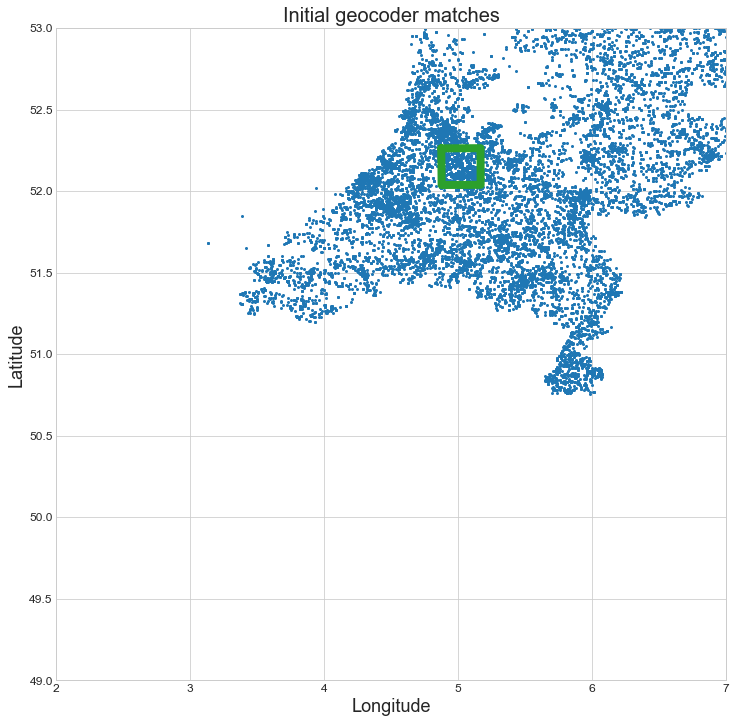

Finding initial region with best matches
len lines: 179


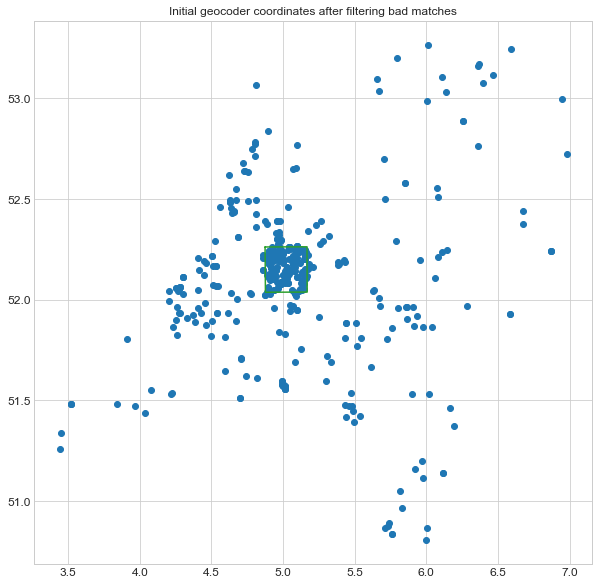


Prefilter filtered out: 3


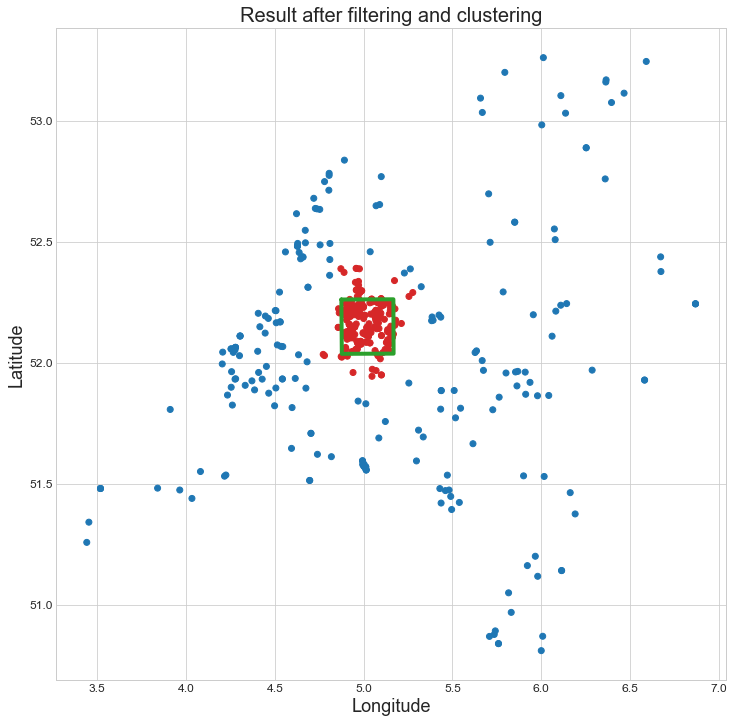

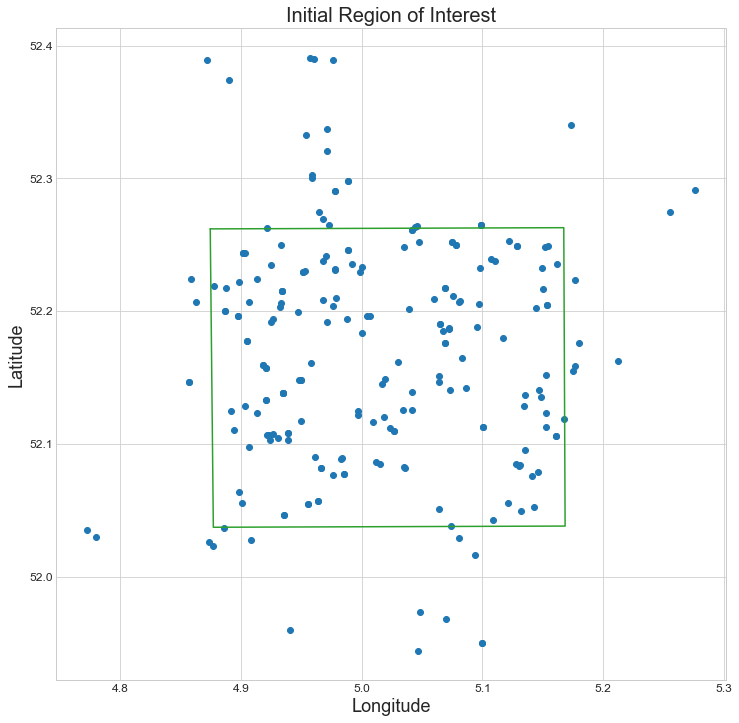

Len lines inside: 115
RANSAC: Best model error: 0.06408163265306116 number of inliers: 70
RANSAC: Average time per iteration: 0.0032 s
lng min: 4.871149625548228
lng max: 5.168622857565096
lat min: 52.03804109599988
lat max: 52.26169835085411


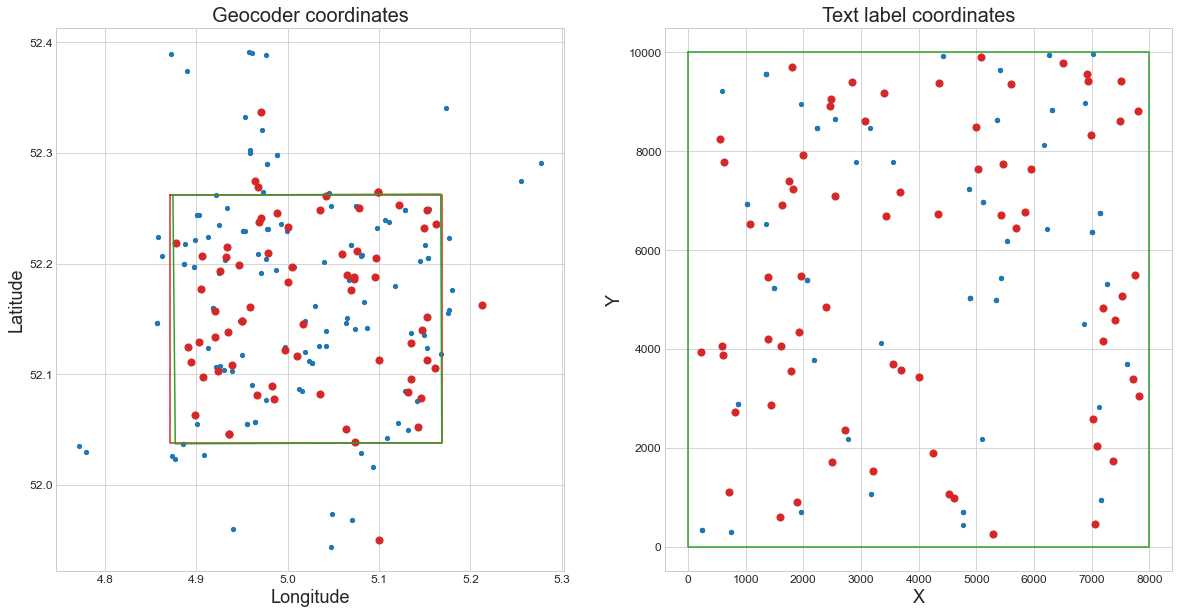

Removed id: 44 min val: -0.08804109599987697

Removed id: 14 min val: -0.07330086052159857

Removed id: 29 min val: -0.042484587054726575

Removed id: 2 min val: -0.012787172622111598

Removed id: 0 min val: -0.008244558138514435

Removed id: 6 min val: -0.004075899534917937

Removed id: 8 min val: -0.0043117749008416695



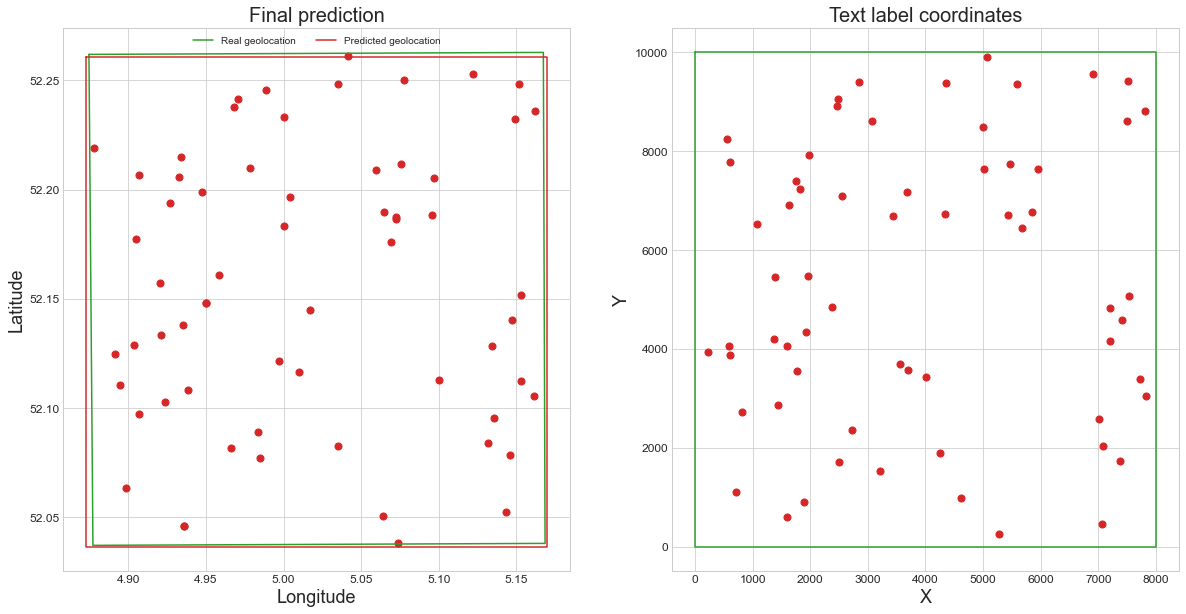


Total processing time: 36 s
[ 4.8727181  52.03665909  5.17002109 52.26074789]
Max dist of bounds: 307 m
Mean dist of bounds: 241 m
Center dist: 152 scale: 0.0047
Amount inside bounds: 0.993


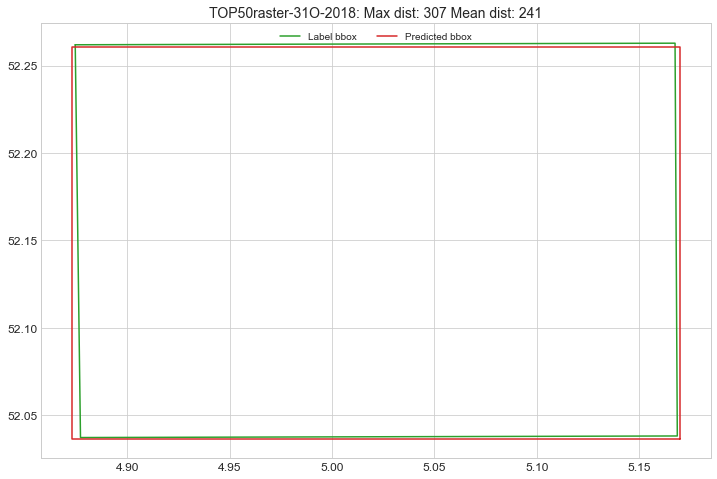


Current file: TOP50raster-32O-2018.jpg
Amount of filtered lines: 497


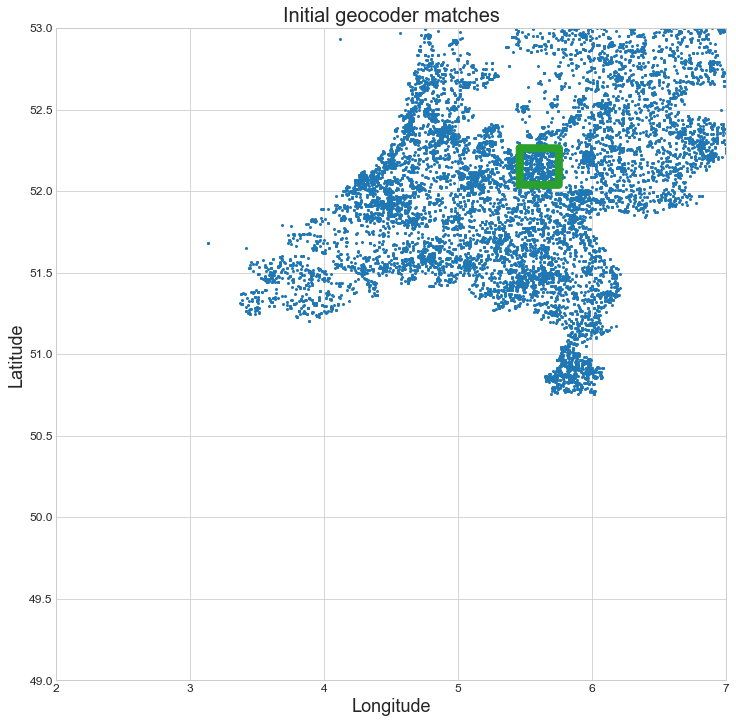

Finding initial region with best matches
len lines: 185


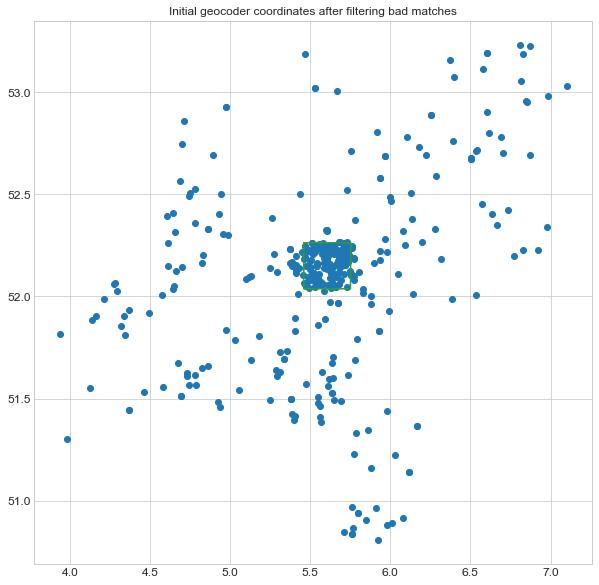


Prefilter filtered out: 1


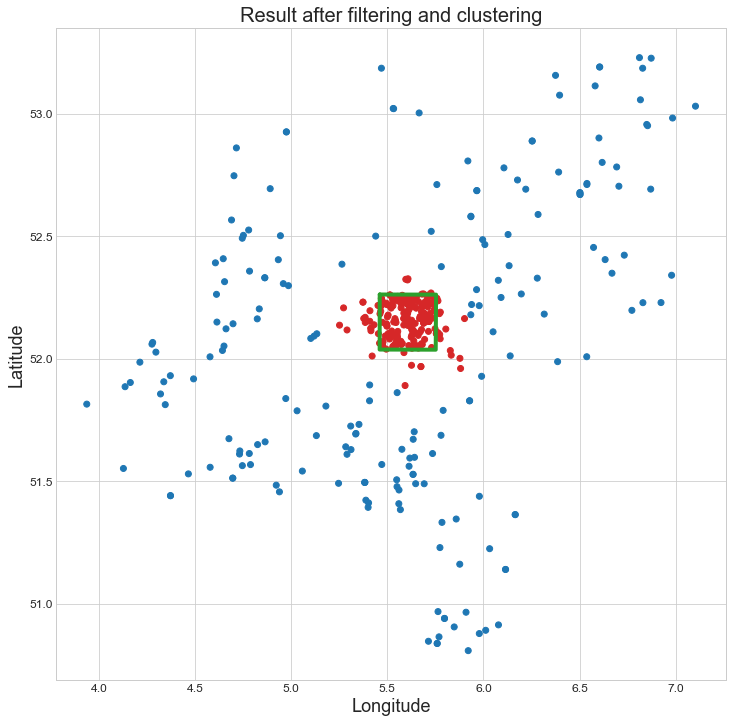

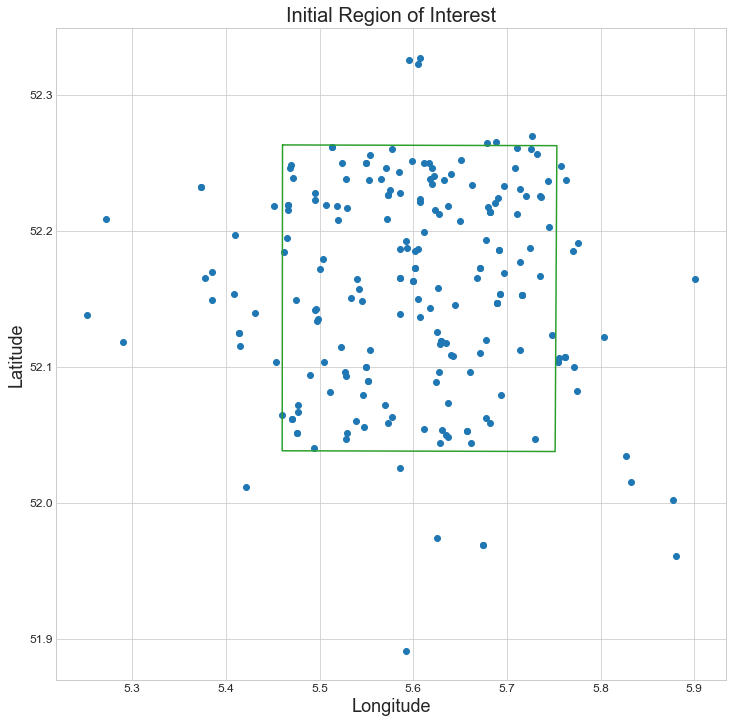

Len lines inside: 131
RANSAC: Best model error: 0.0875850340136054 number of inliers: 84
RANSAC: Average time per iteration: 0.00382 s
lng min: 5.452647942105922
lng max: 5.748926867943172
lat min: 52.04064747024359
lat max: 52.26236323224831


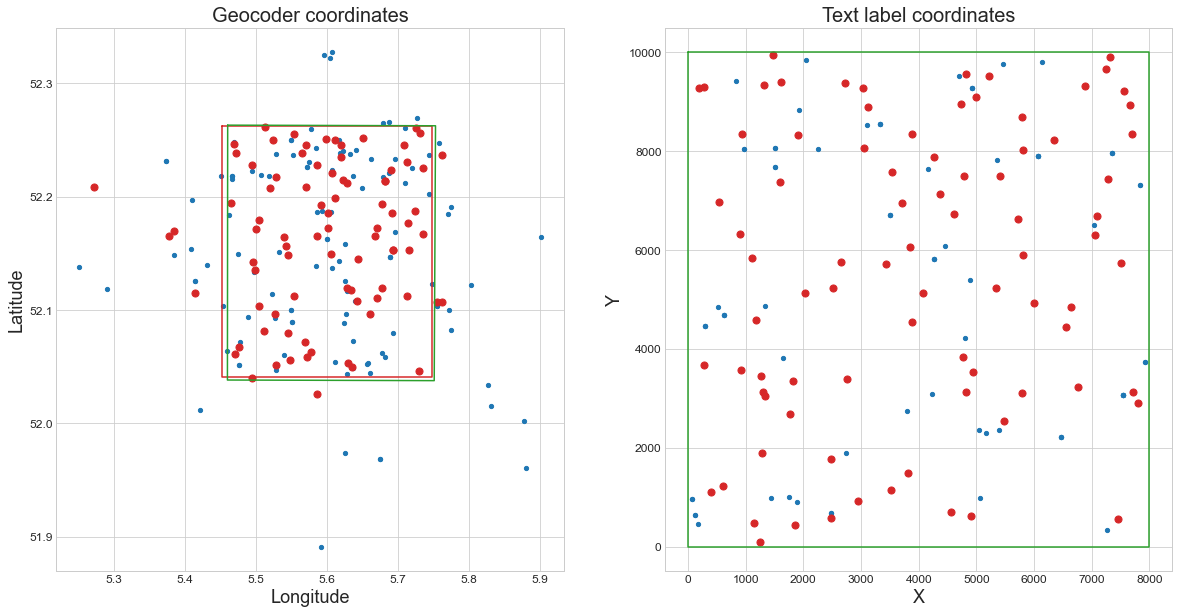

Removed id: 49 min val: -0.18024794210592177

Removed id: 55 min val: -0.07948533661295976

Removed id: 47 min val: -0.07474066701166837

Removed id: 47 min val: -0.046137328872878136

Removed id: 46 min val: -0.010812234628005513

Removed id: 18 min val: -0.010442999835954758

Removed id: 49 min val: -0.010762442102015157

Removed id: 48 min val: -0.00463080730094223



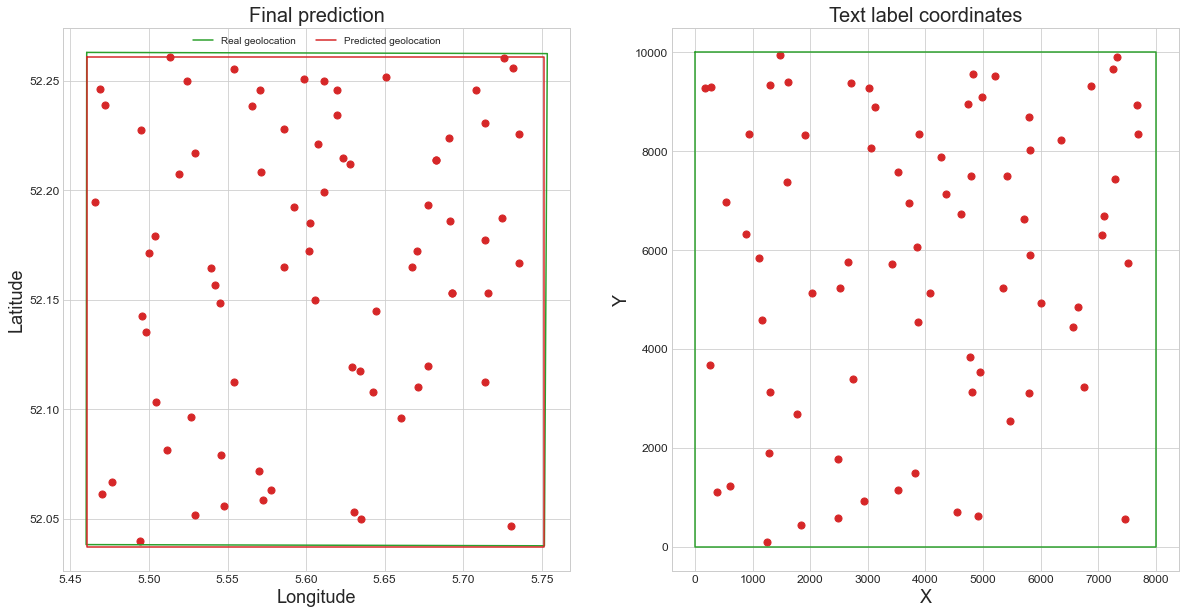


Total processing time: 43 s
[ 5.46052327 52.03739548  5.75143668 52.26101686]
Max dist of bounds: 221 m
Mean dist of bounds: 144 m
Center dist: 134 scale: 0.0042
Amount inside bounds: 0.988


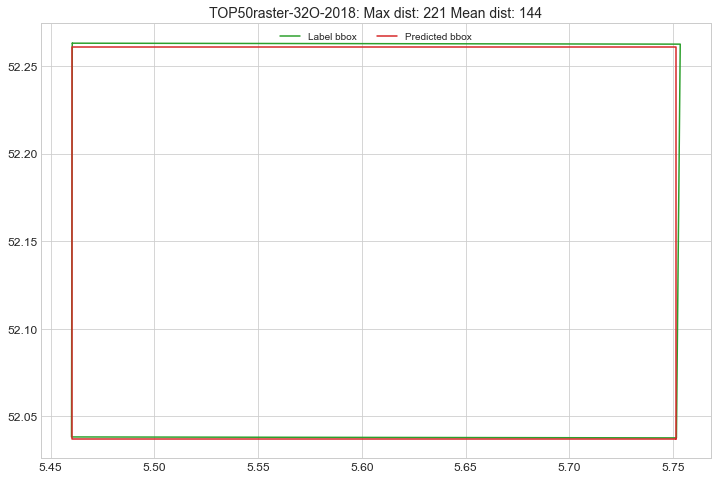


Current file: TOP50raster-32W-2018.jpg
Amount of filtered lines: 528


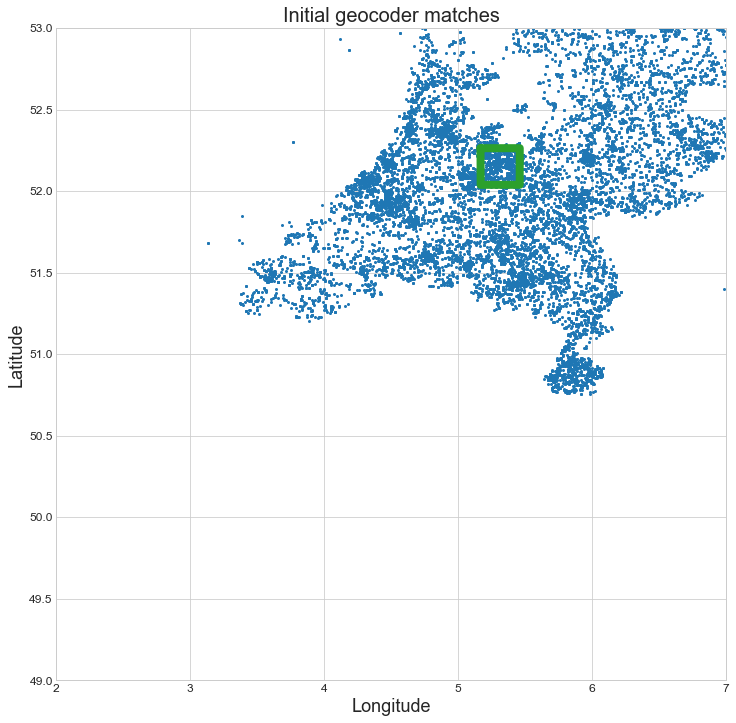

Finding initial region with best matches
len lines: 175


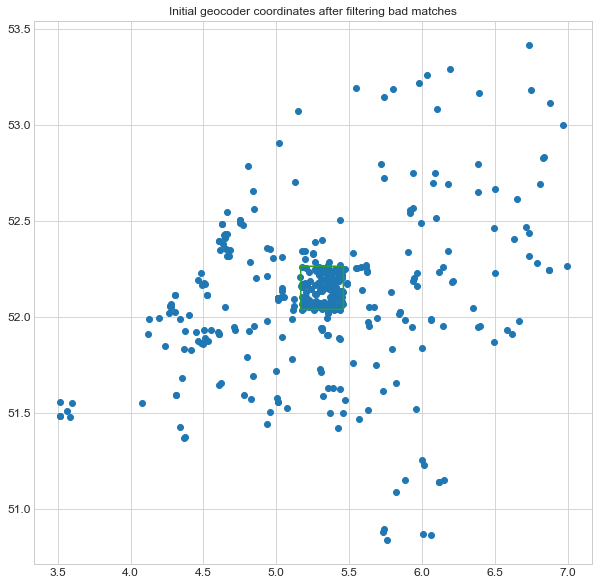


Prefilter filtered out: 1


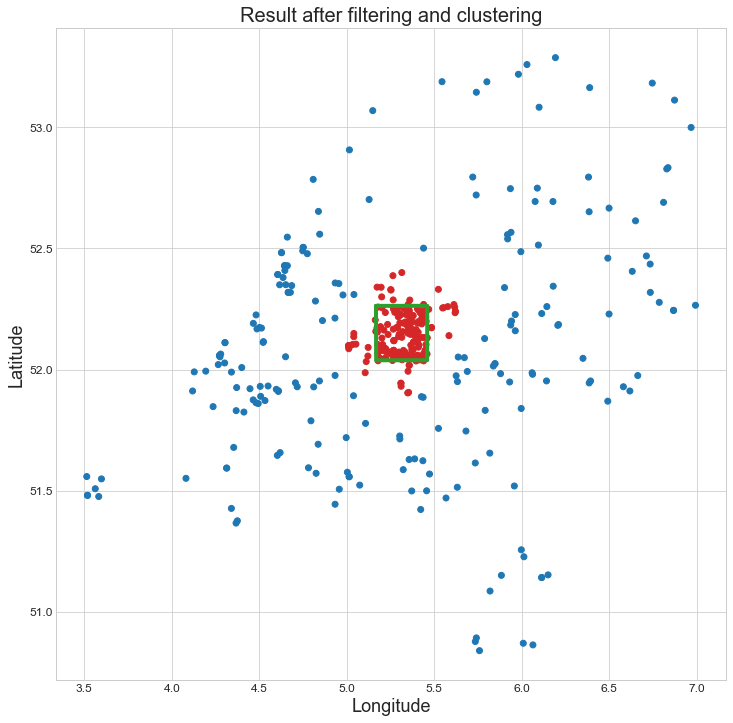

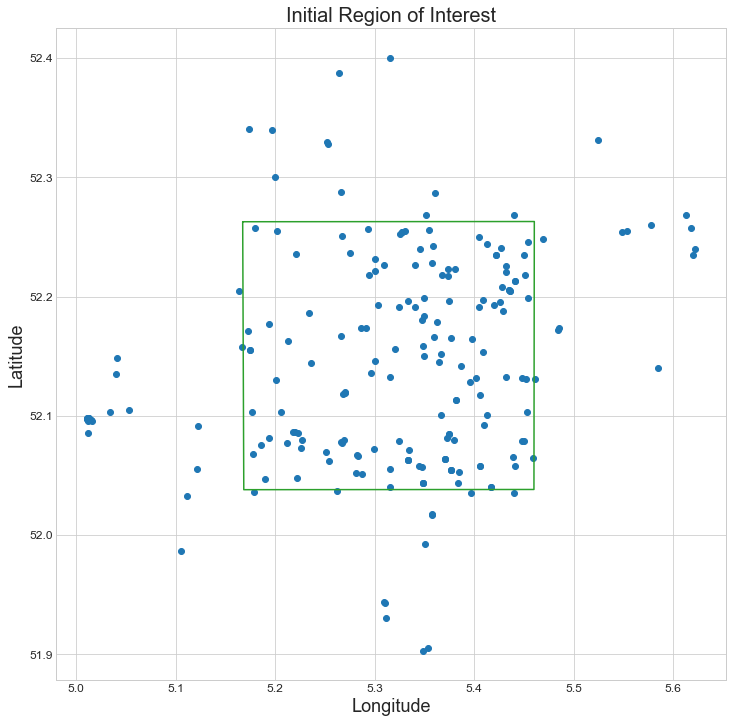

Len lines inside: 124
RANSAC: Best model error: 0.07407407407407408 number of inliers: 72
RANSAC: Average time per iteration: 0.00353 s
lng min: 5.151093702753547
lng max: 5.463937913381355
lat min: 52.03984018529904
lat max: 52.26326711930834


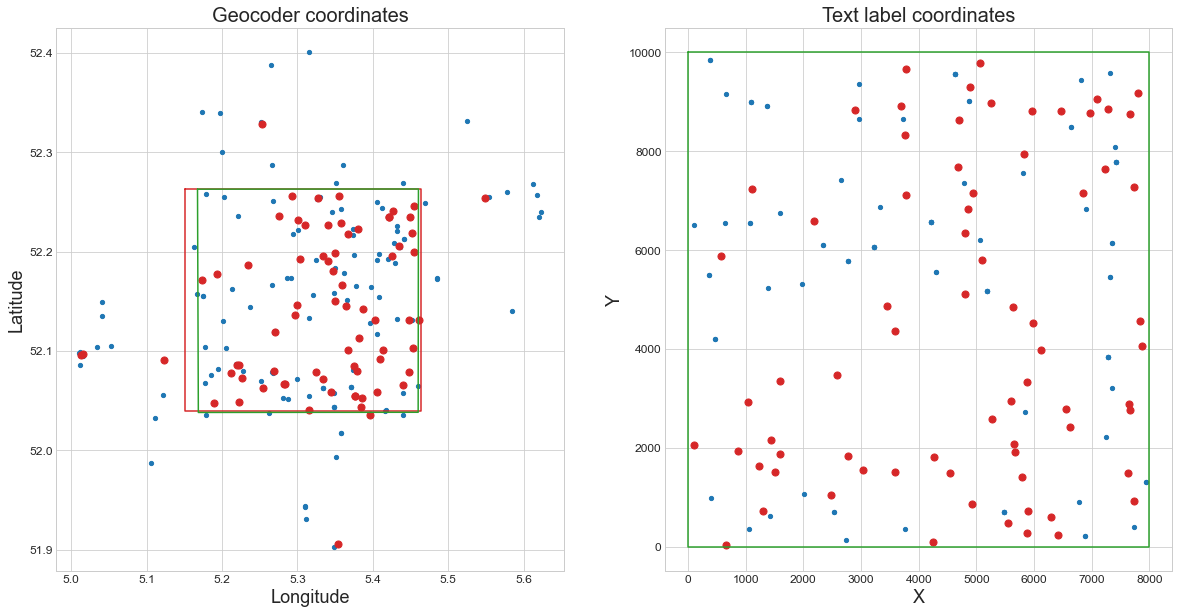

Removed id: 25 min val: -0.13857370275354697

Removed id: 25 min val: -0.1471558984074246

Removed id: 28 min val: -0.1350985429843803

Removed id: 30 min val: -0.08575515955946322

Removed id: 13 min val: -0.0659891811510036

Removed id: 24 min val: -0.039316793529428296

Removed id: 44 min val: -0.004012821560188229



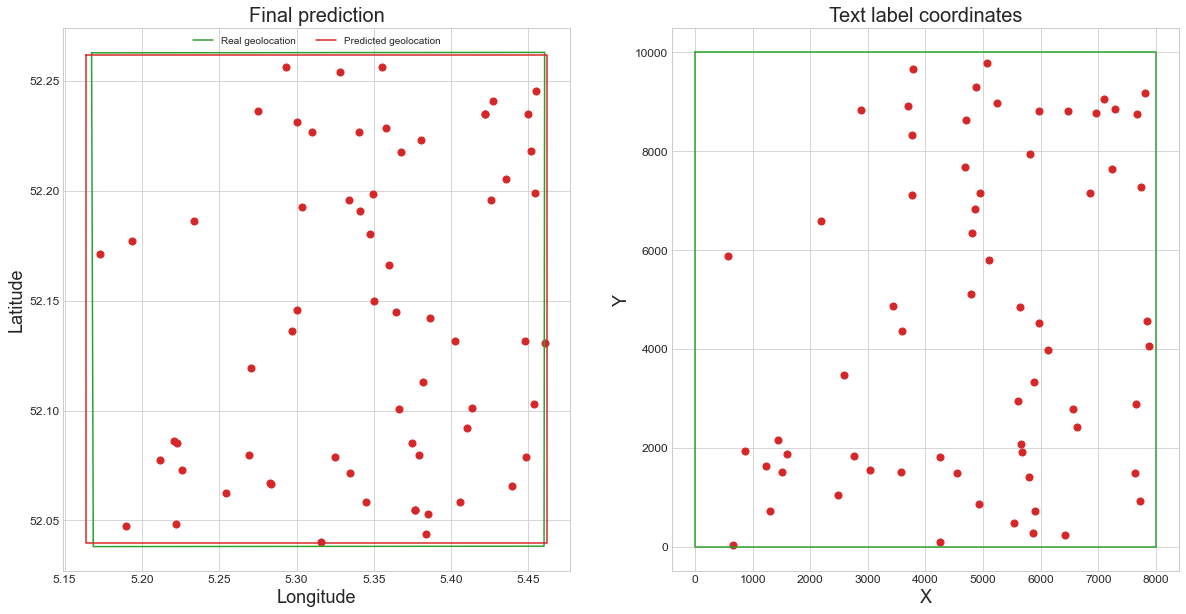


Total processing time: 41 s
[ 5.16396445 52.03959553  5.46216733 52.26196477]
Max dist of bounds: 356 m
Mean dist of bounds: 245 m
Center dist: 78 scale: 0.0024
Amount inside bounds: 0.99


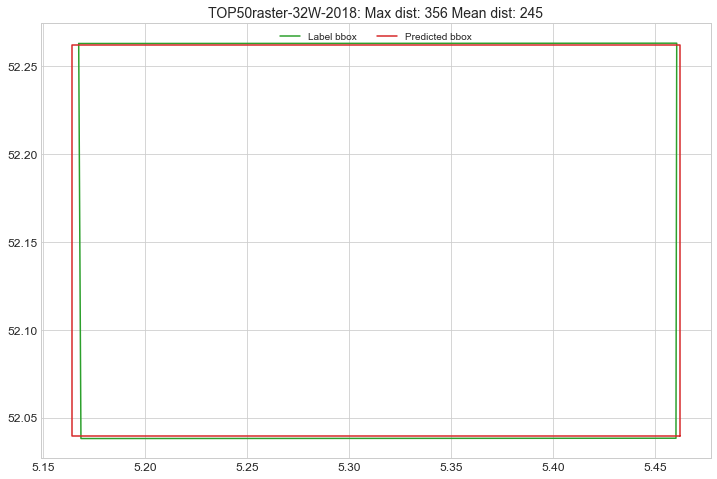


Current file: TOP50raster-38O-2018.jpg
Amount of filtered lines: 568


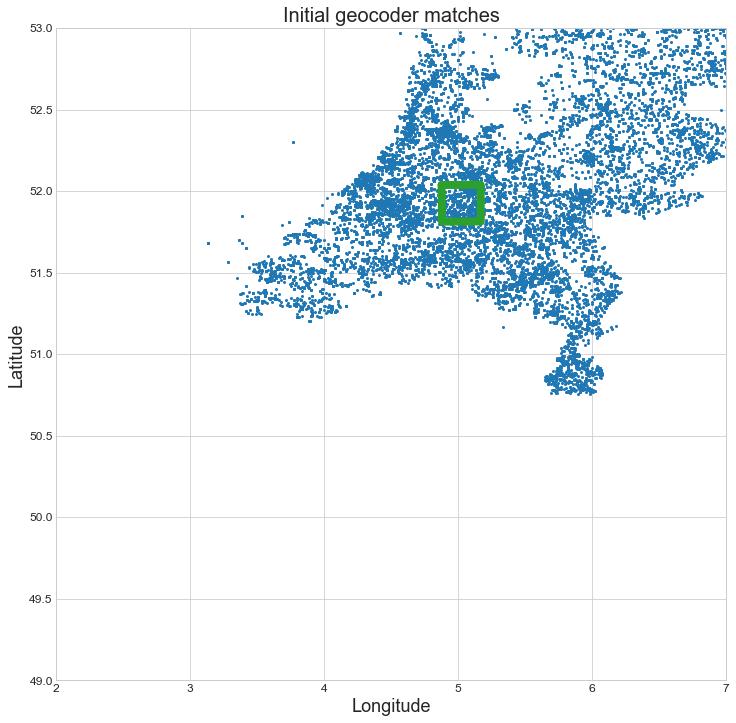

Finding initial region with best matches
len lines: 170


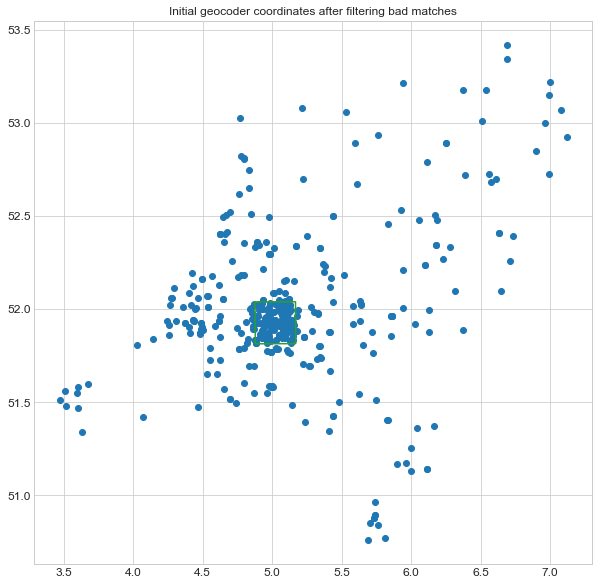


Prefilter filtered out: 3


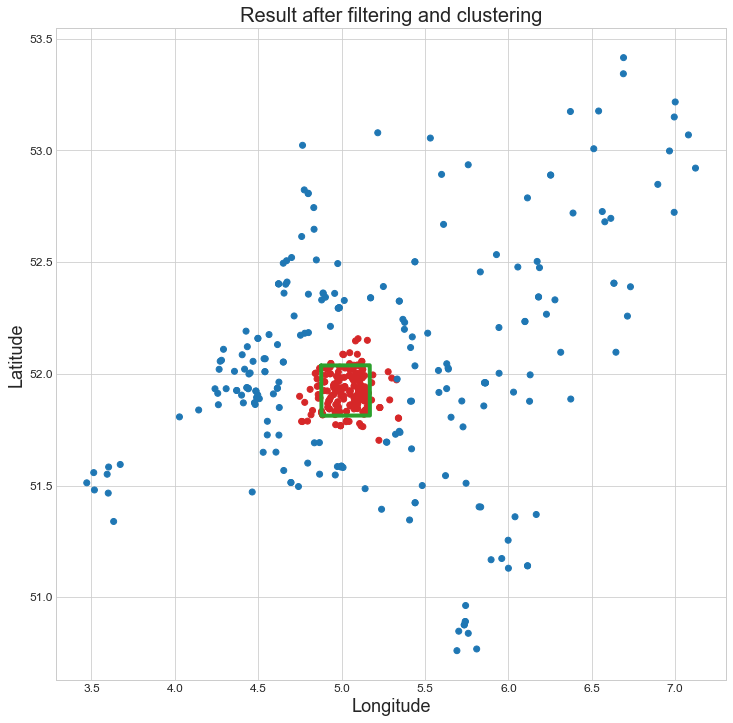

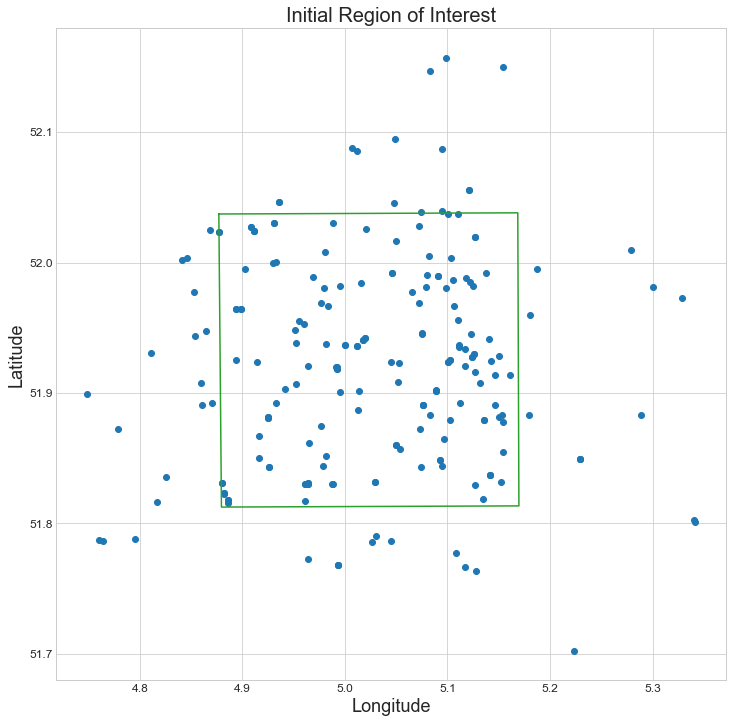

Len lines inside: 125
RANSAC: Best model error: 0.07785467128027676 number of inliers: 68
RANSAC: Average time per iteration: 0.00352 s
lng min: 4.883513114551837
lng max: 5.169879880606502
lat min: 51.81387206818775
lat max: 52.04450328062988


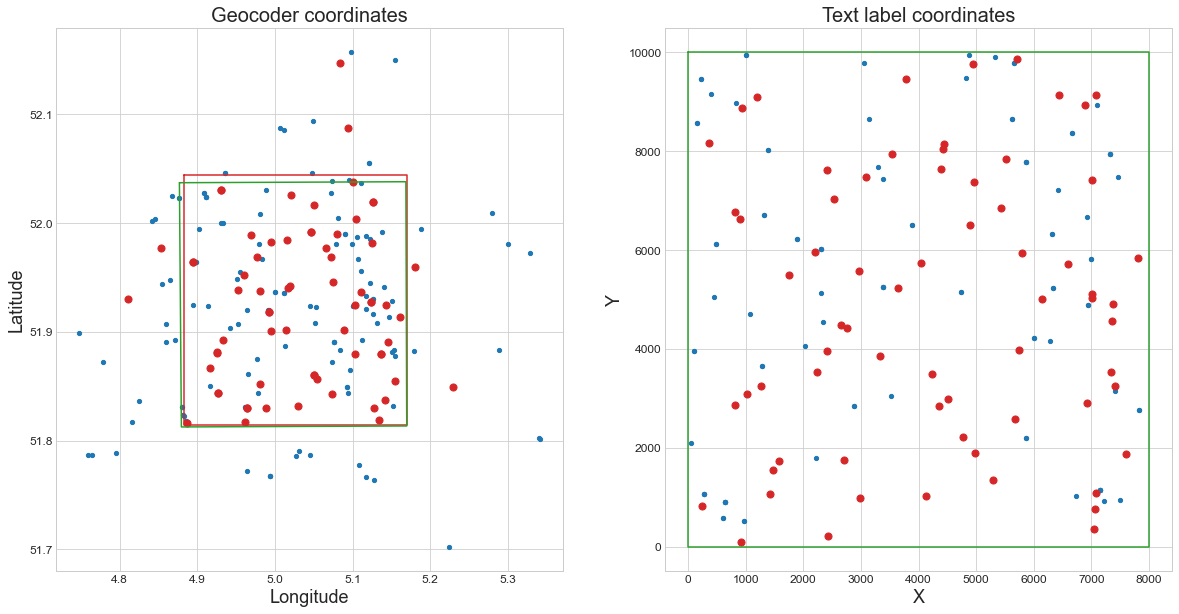

Removed id: 3 min val: -0.10270671937011855

Removed id: 29 min val: -0.07161991624678077

Removed id: 45 min val: -0.055985003821116486

Removed id: 17 min val: -0.046100042303052646

Removed id: 1 min val: -0.03221677041323989

Removed id: 16 min val: -0.011618927951414726



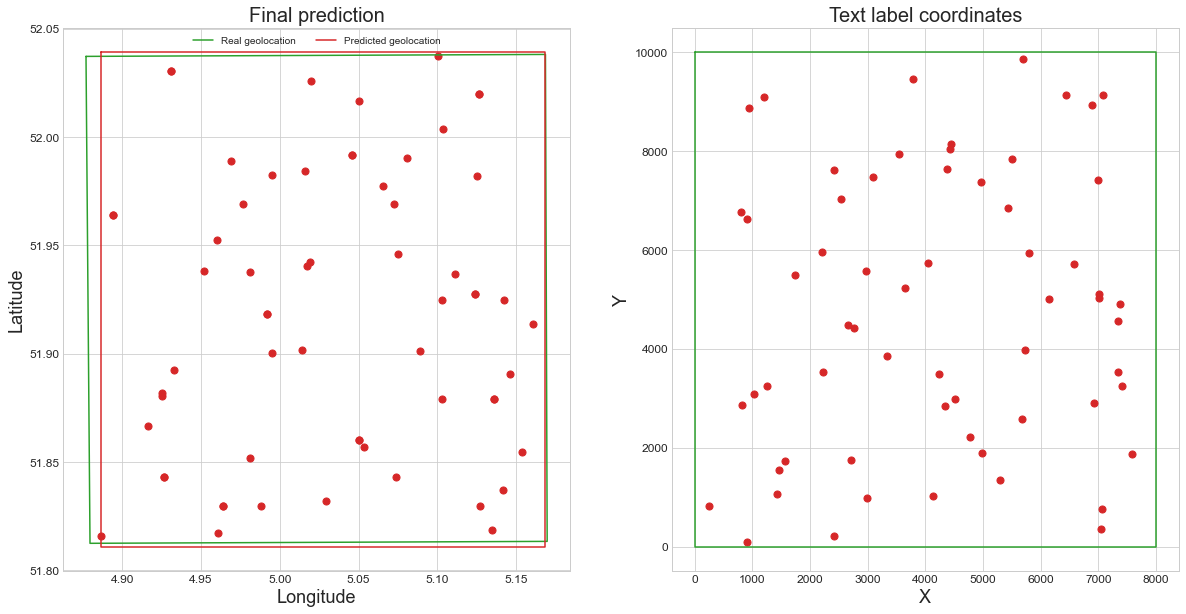


Total processing time: 41 s
[ 4.88632415 51.81101065  5.16834507 52.03905917]
Max dist of bounds: 663 m
Mean dist of bounds: 385 m
Center dist: 248 scale: 0.0077
Amount inside bounds: 0.97


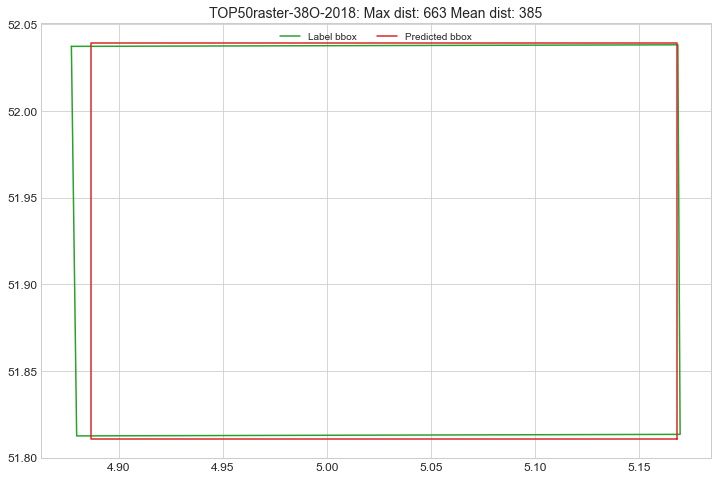


Current file: TOP50raster-39O-2018.jpg
Amount of filtered lines: 555


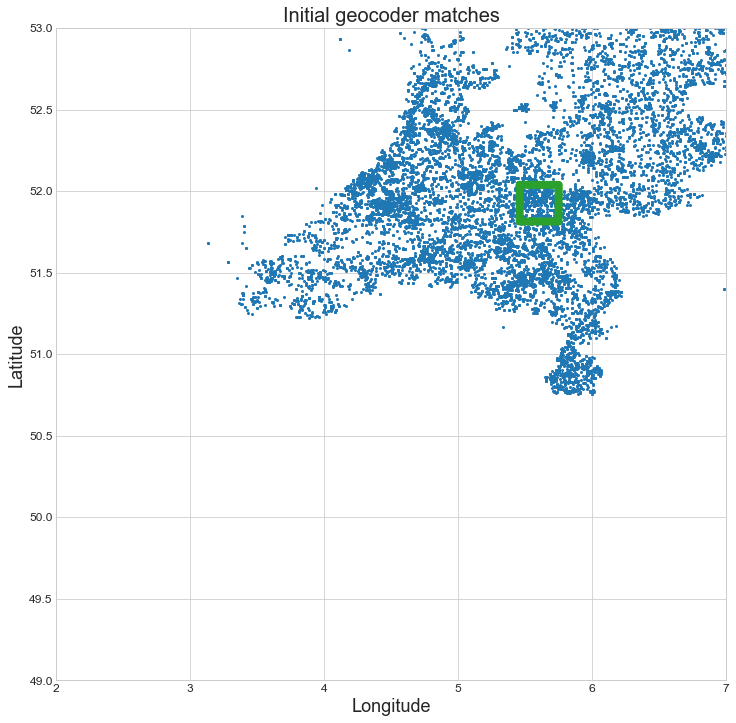

Finding initial region with best matches
len lines: 186


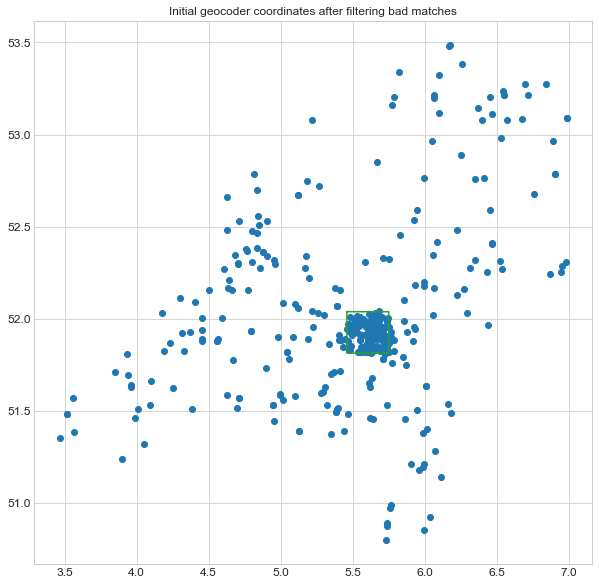


Prefilter filtered out: 1


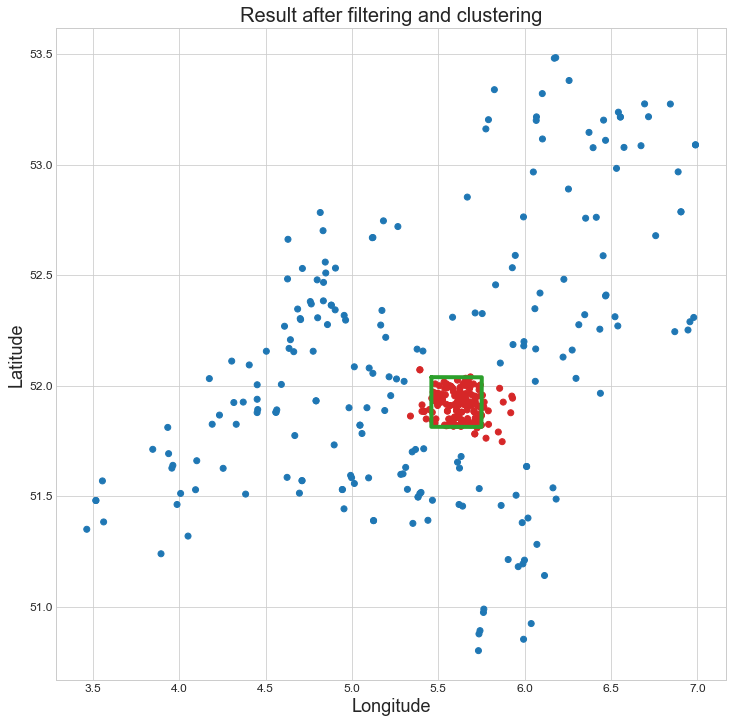

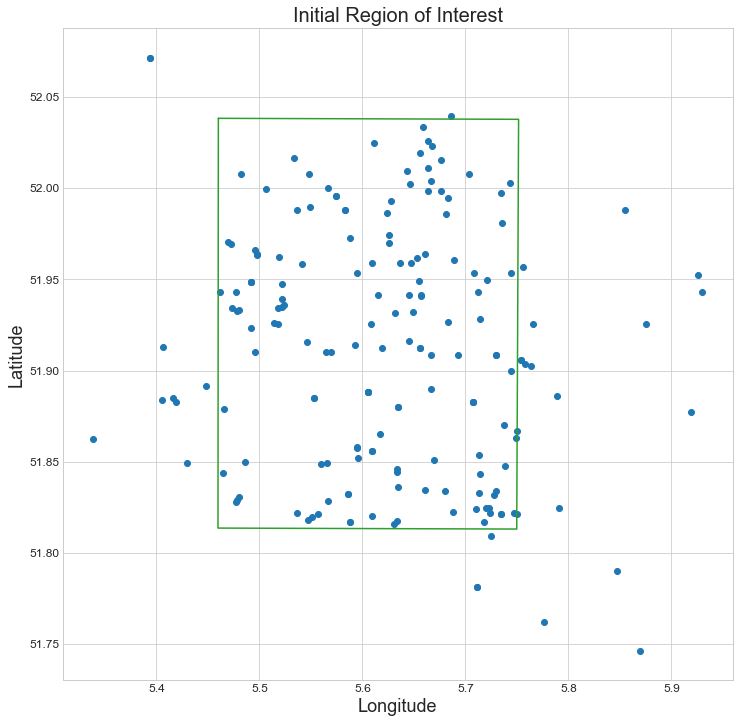

Len lines inside: 115
RANSAC: Best model error: 0.04355555555555558 number of inliers: 75
RANSAC: Average time per iteration: 0.00334 s
lng min: 5.458411727339717
lng max: 5.754698241709655
lat min: 51.811995639015585
lat max: 52.03863926423868


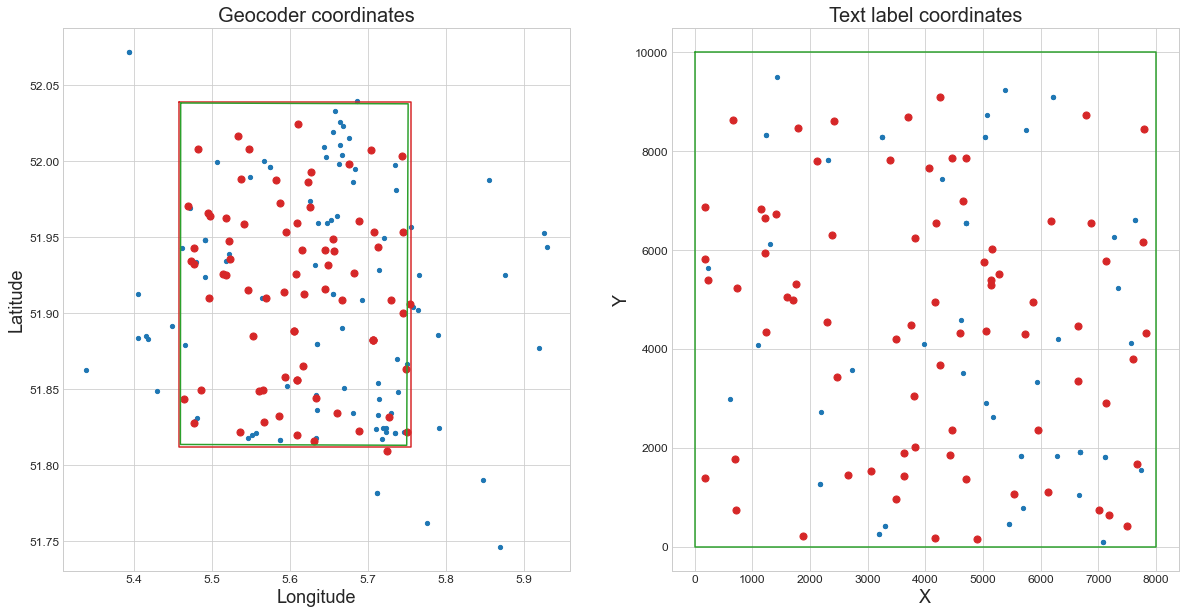

Removed id: 42 min val: -0.0028256390155831923



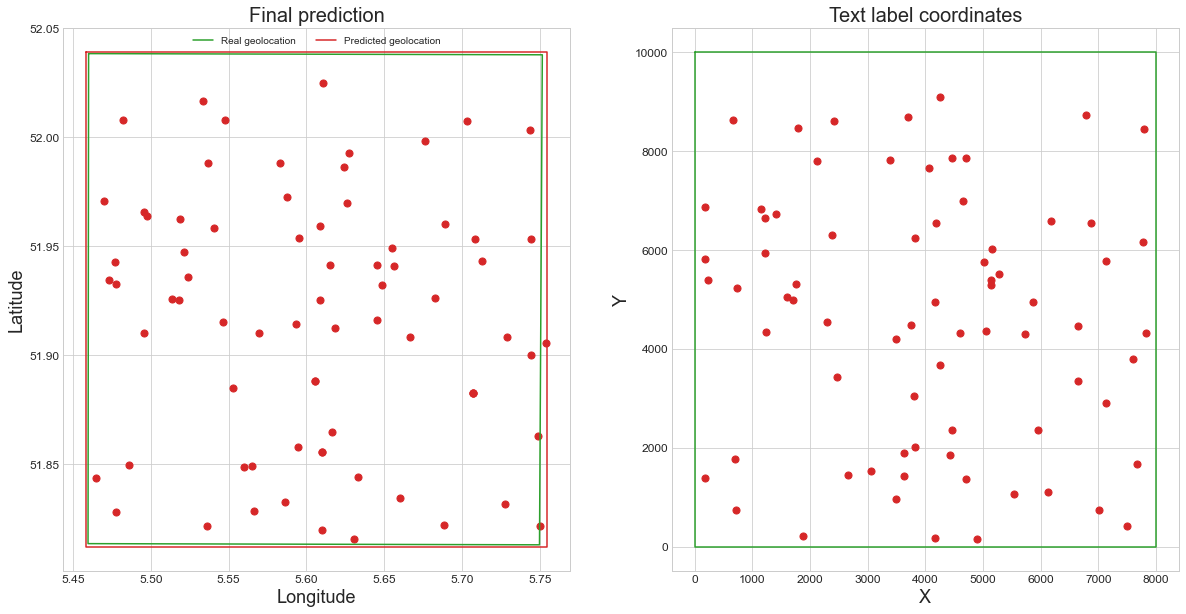


Total processing time: 38 s
[ 5.45841188 51.81224098  5.75467889 52.03885669]
Max dist of bounds: 351 m
Mean dist of bounds: 225 m
Center dist: 88 scale: 0.0028
Amount inside bounds: 1.0


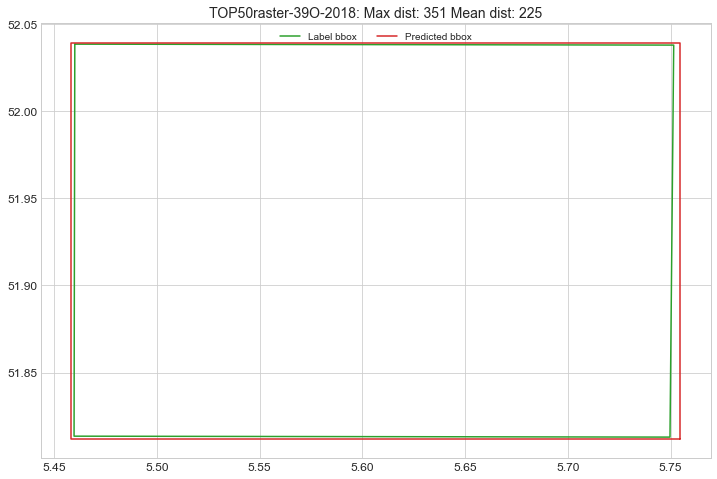


Current file: TOP50raster-39W-2018.jpg
Amount of filtered lines: 692


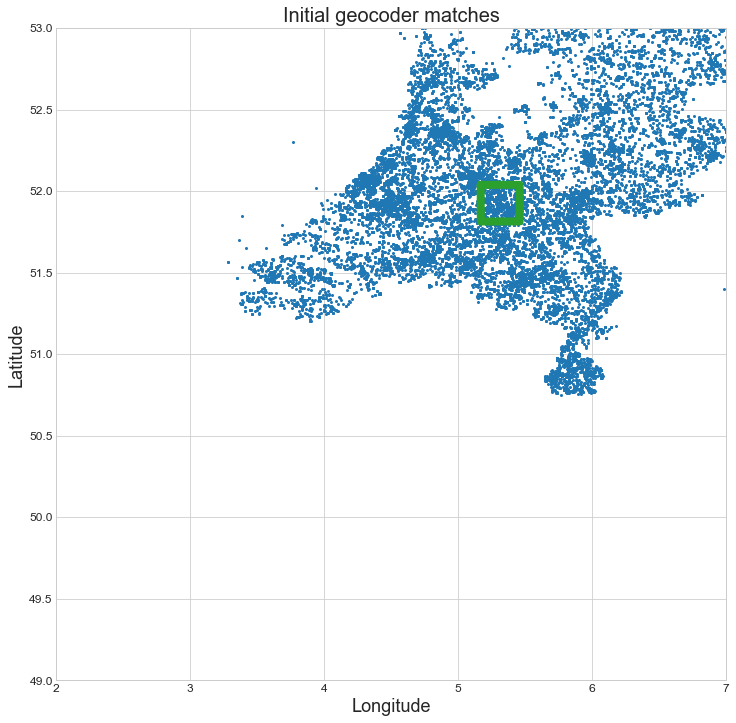

Finding initial region with best matches
len lines: 200


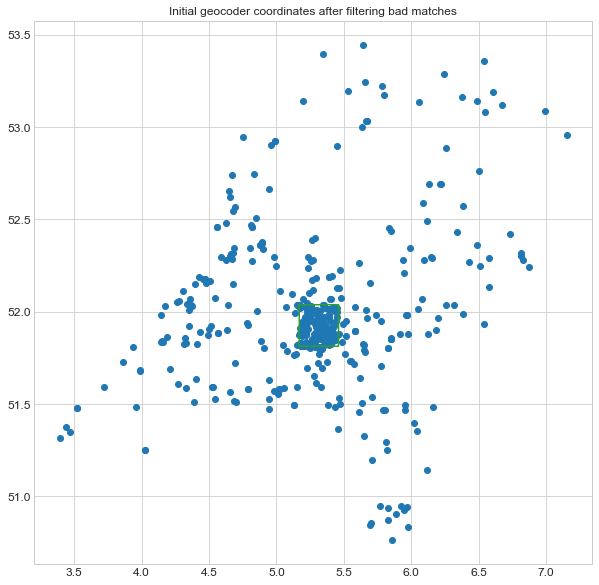


Prefilter filtered out: 0


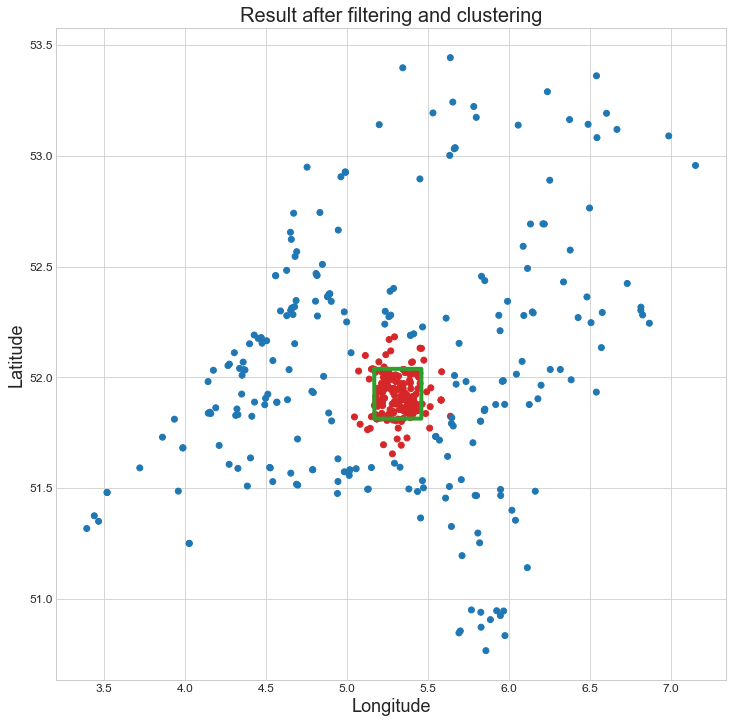

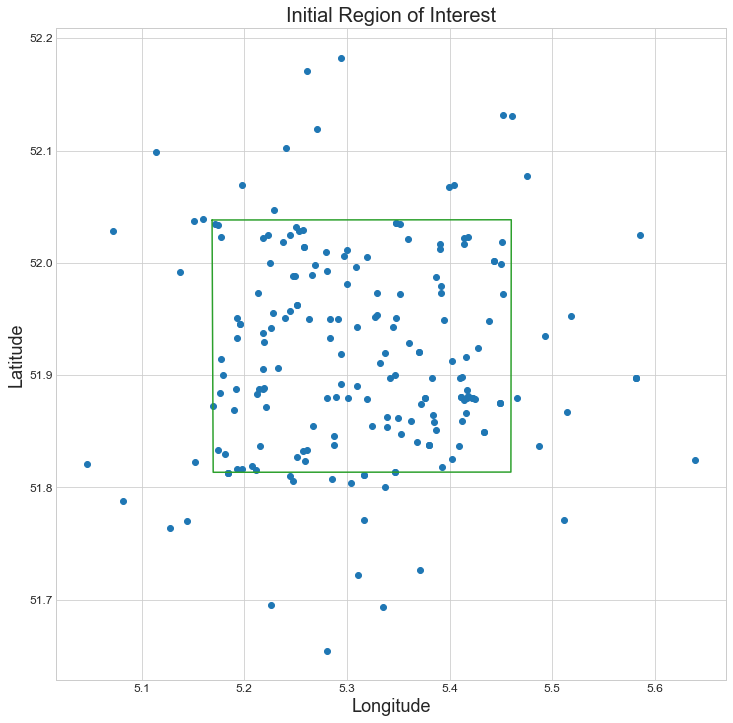

Len lines inside: 119
RANSAC: Best model error: 0.08589565562388417 number of inliers: 71
RANSAC: Average time per iteration: 0.00335 s
lng min: 5.171516489971222
lng max: 5.4593422533668825
lat min: 51.811939453556676
lat max: 52.038194926732885


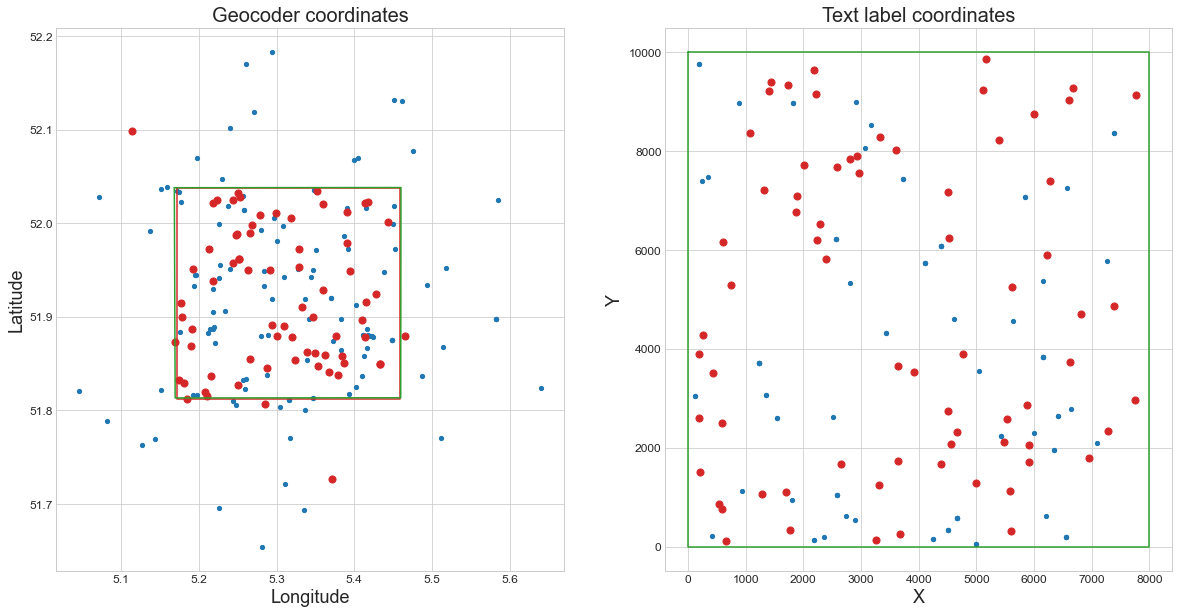

Removed id: 45 min val: -0.0855594535566766

Removed id: 5 min val: -0.058429347484334926

Removed id: 27 min val: -0.007275883221994128

Removed id: 36 min val: -0.005792087518393885

Removed id: 44 min val: -0.005298387421817097

Removed id: 39 min val: -0.0024005633506298807



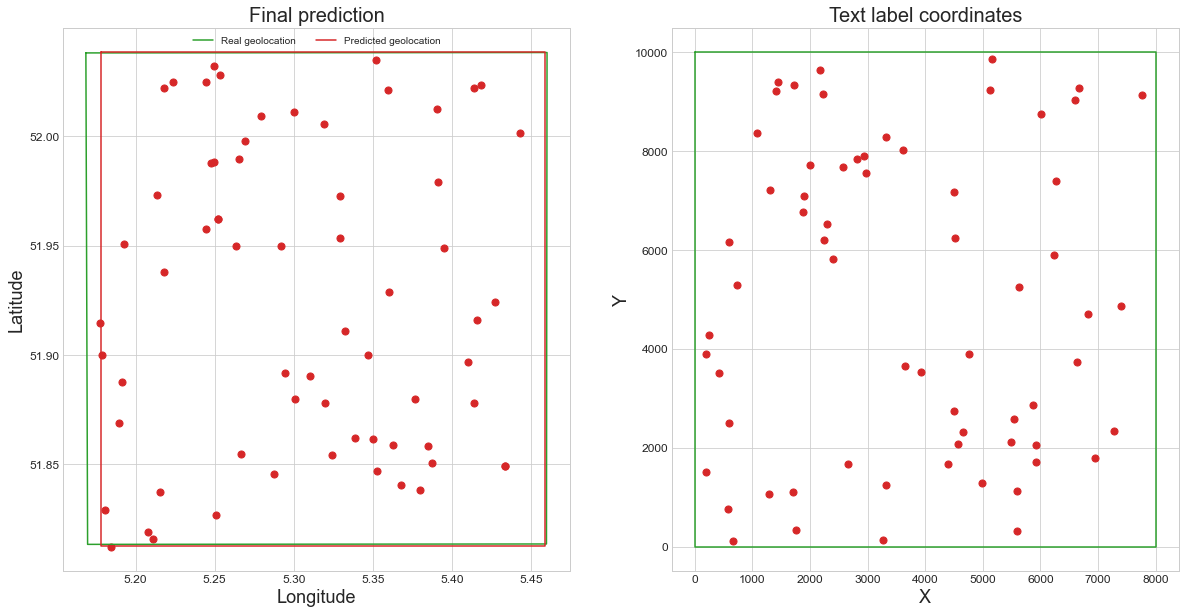


Total processing time: 39 s
[ 5.1779988  51.81273642  5.45869821 52.03835856]
Max dist of bounds: 644 m
Mean dist of bounds: 359 m
Center dist: 265 scale: 0.0083
Amount inside bounds: 0.965


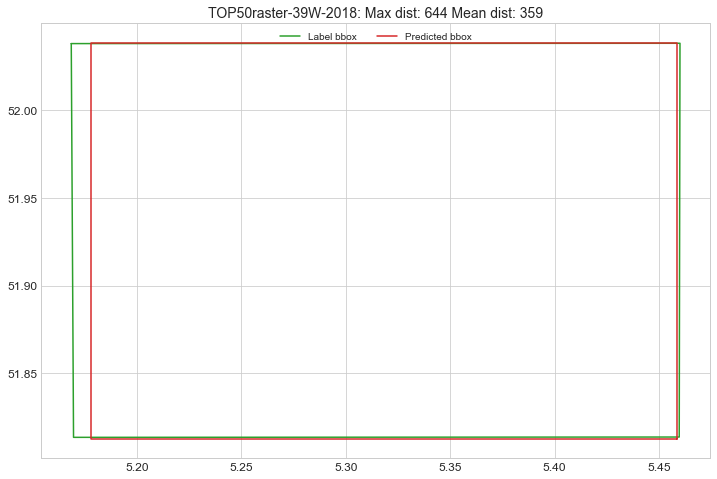


Current file: TOP50raster-44O-2018.jpg
Amount of filtered lines: 632


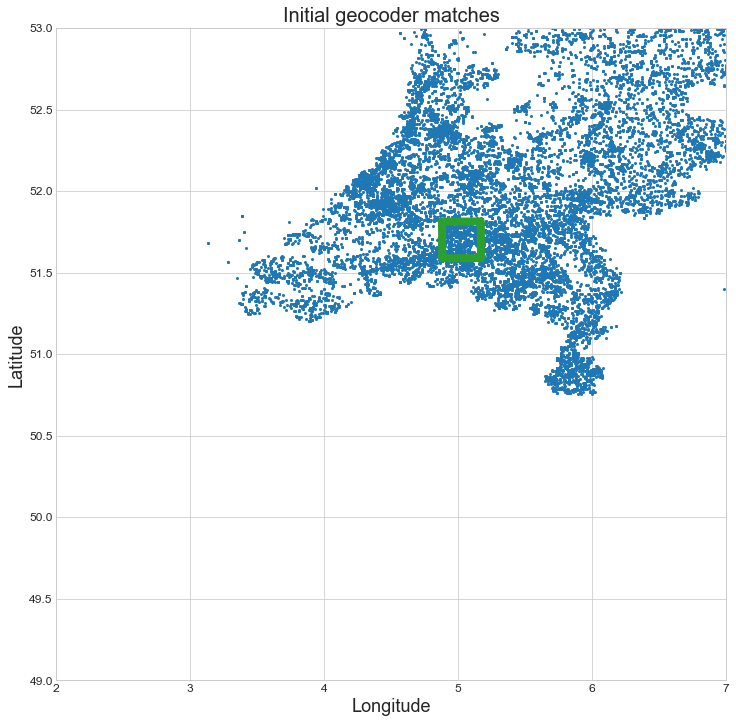

Finding initial region with best matches
len lines: 189


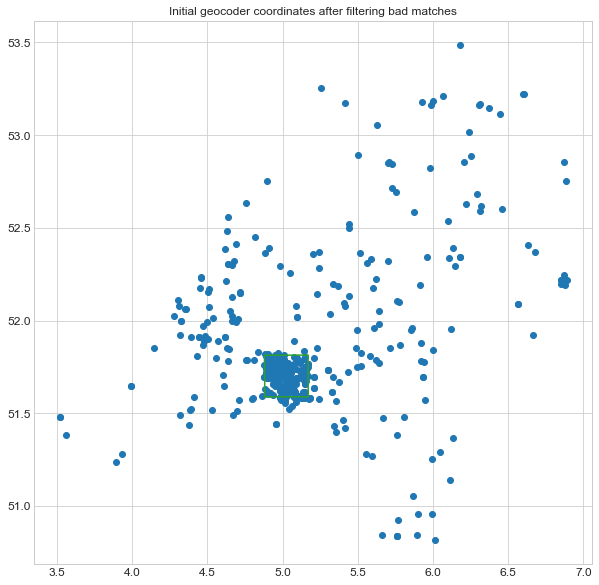


Prefilter filtered out: 1


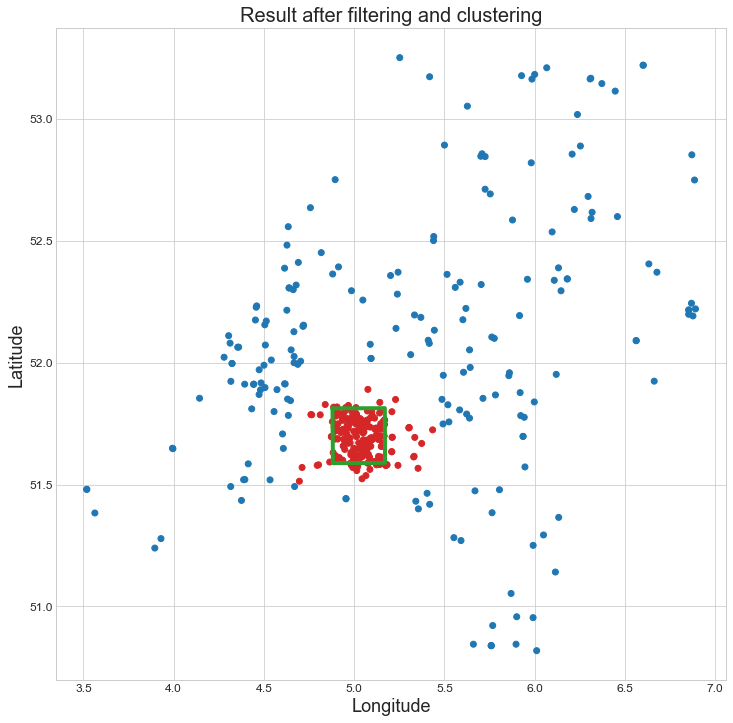

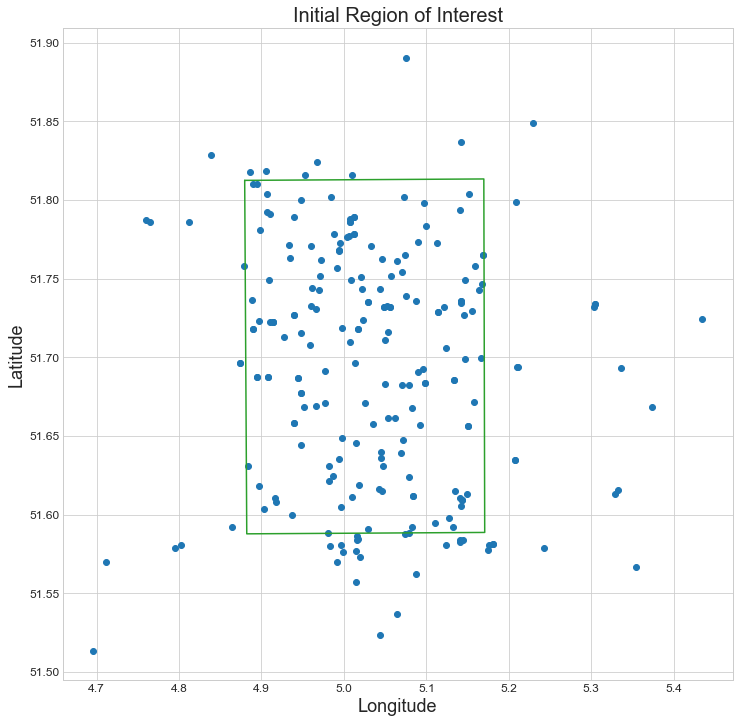

Len lines inside: 132
RANSAC: Best model error: 0.0881076388888889 number of inliers: 96
RANSAC: Average time per iteration: 0.004 s
lng min: 4.881245978386105
lng max: 5.170744084154965
lat min: 51.58530596654458
lat max: 51.81095774039256


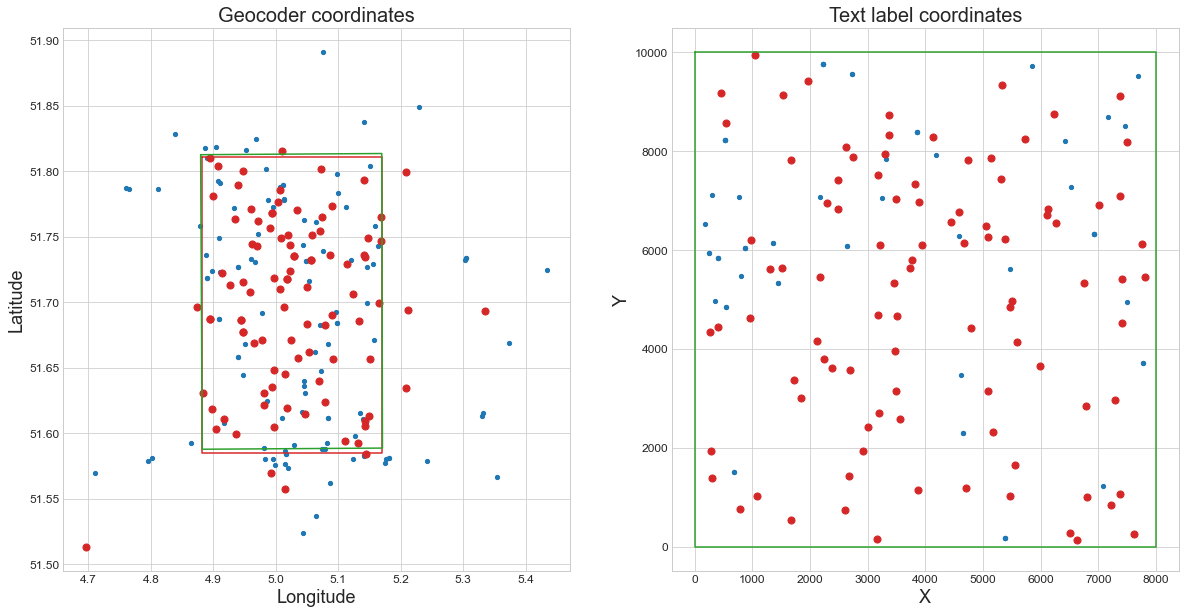

Removed id: 32 min val: -0.18511597838610516

Removed id: 22 min val: -0.15659216932489084

Removed id: 38 min val: -0.039361953672529815

Removed id: 20 min val: -0.039369844620603445

Removed id: 55 min val: -0.04195396808408791

Removed id: 22 min val: -0.029650565045450605

Removed id: 53 min val: -0.019053401456474717

Removed id: 25 min val: -0.007906501346601758

Removed id: 55 min val: -0.005020273646486828

Removed id: 8 min val: -0.0017288929408181275



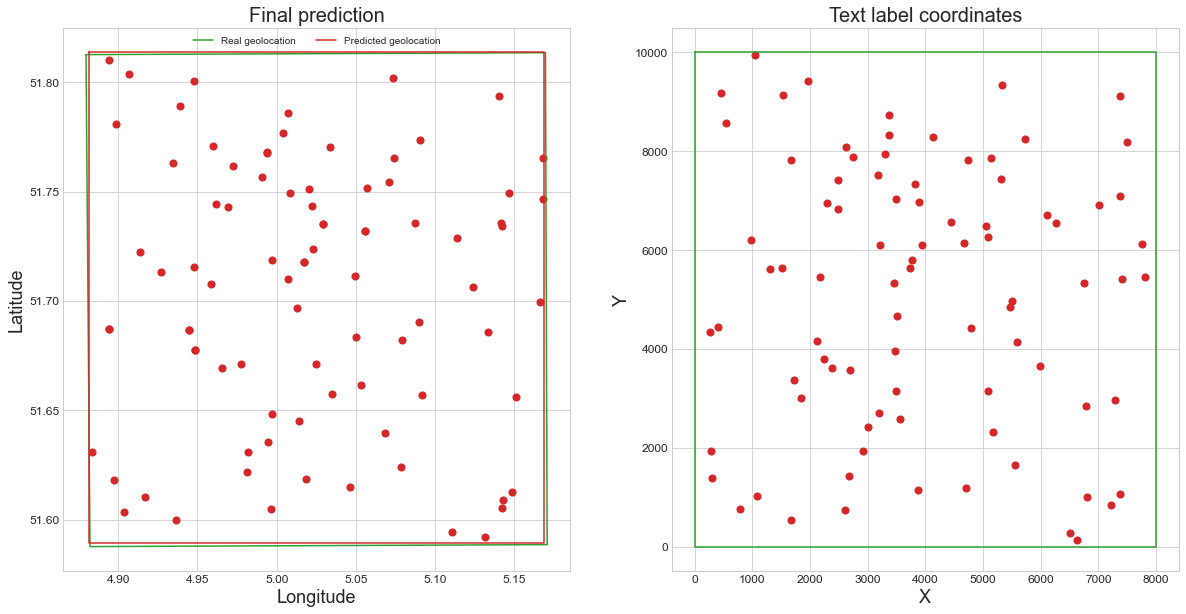


Total processing time: 46 s
[ 4.88167302 51.58937027  5.16870042 51.81353872]
Max dist of bounds: 180 m
Mean dist of bounds: 146 m
Center dist: 97 scale: 0.003
Amount inside bounds: 0.987


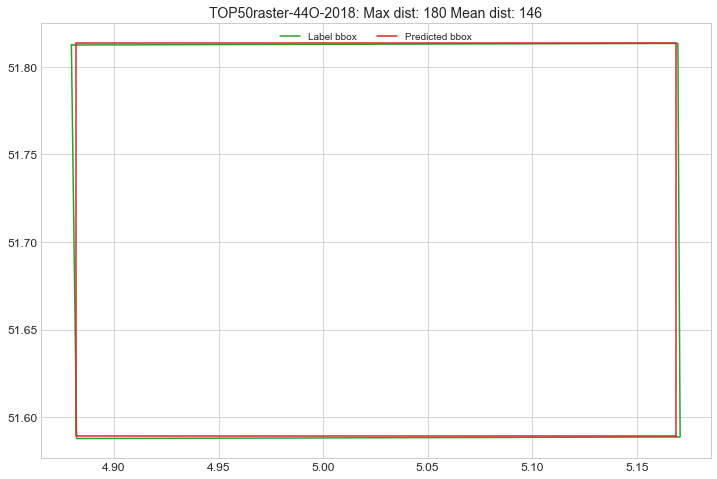


Current file: TOP50raster-45O-2018.jpg
Amount of filtered lines: 561


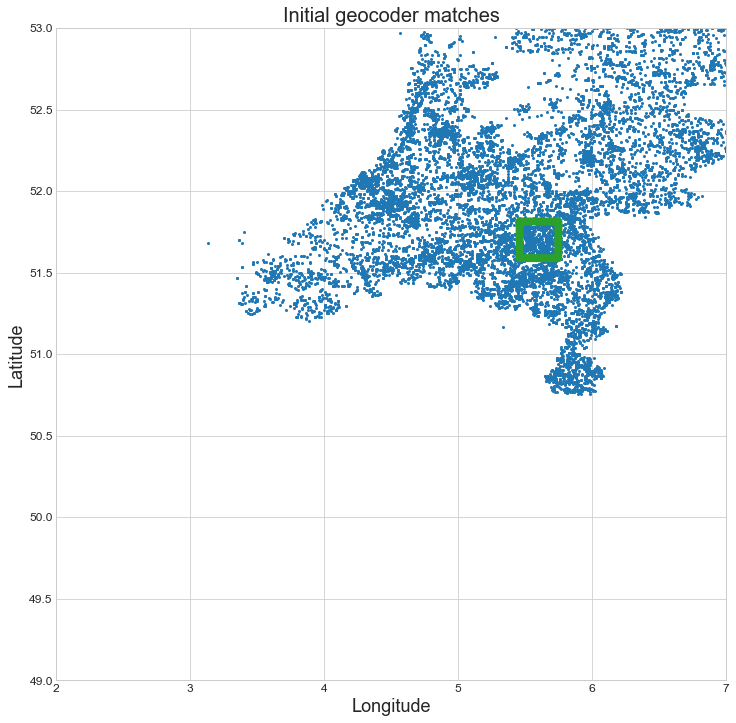

Finding initial region with best matches
len lines: 194


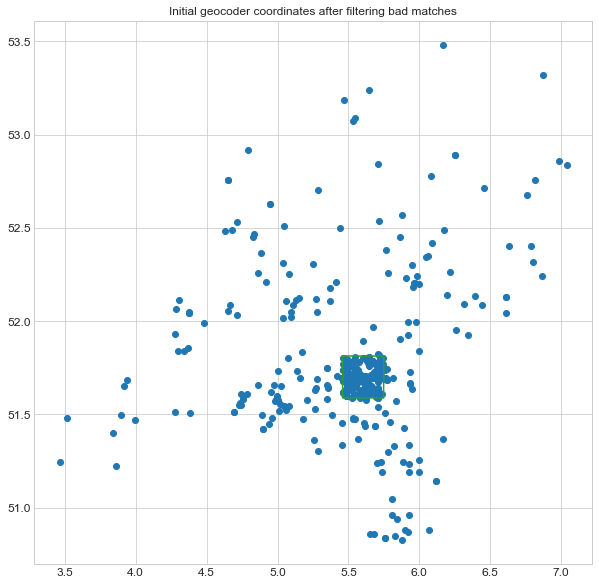


Prefilter filtered out: 4


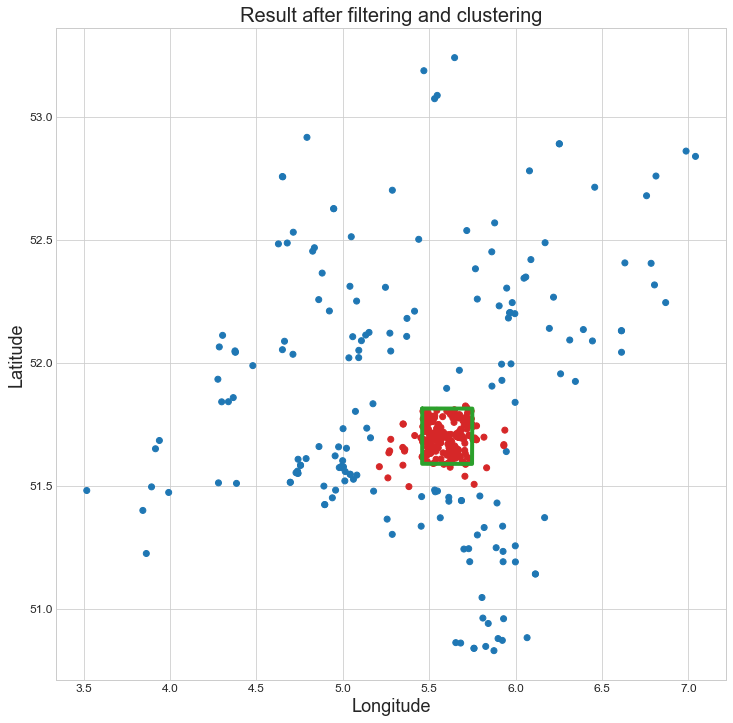

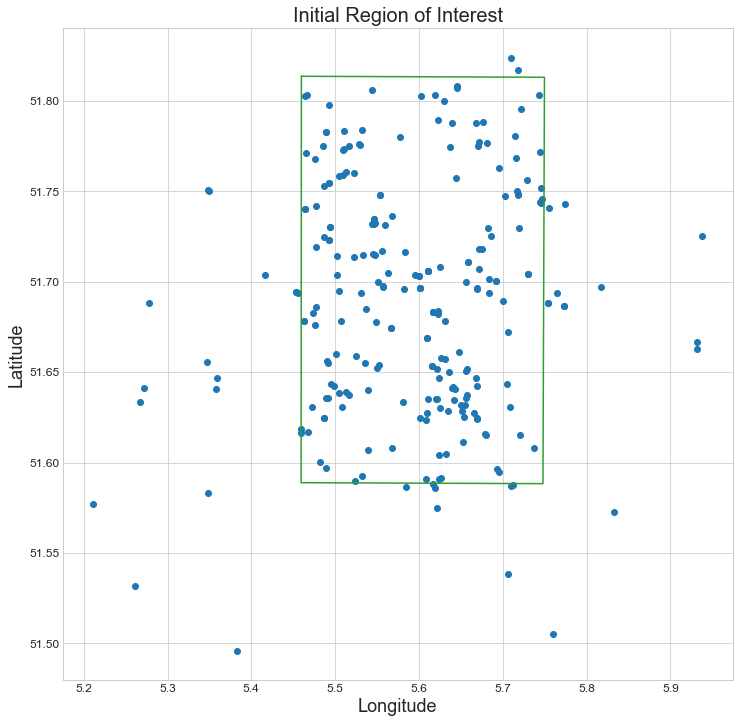

Len lines inside: 145
RANSAC: Best model error: 0.056490384615384664 number of inliers: 104
RANSAC: Average time per iteration: 0.0042 s
lng min: 5.462097914702641
lng max: 5.745567535041945
lat min: 51.59087077033199
lat max: 51.813868641883815


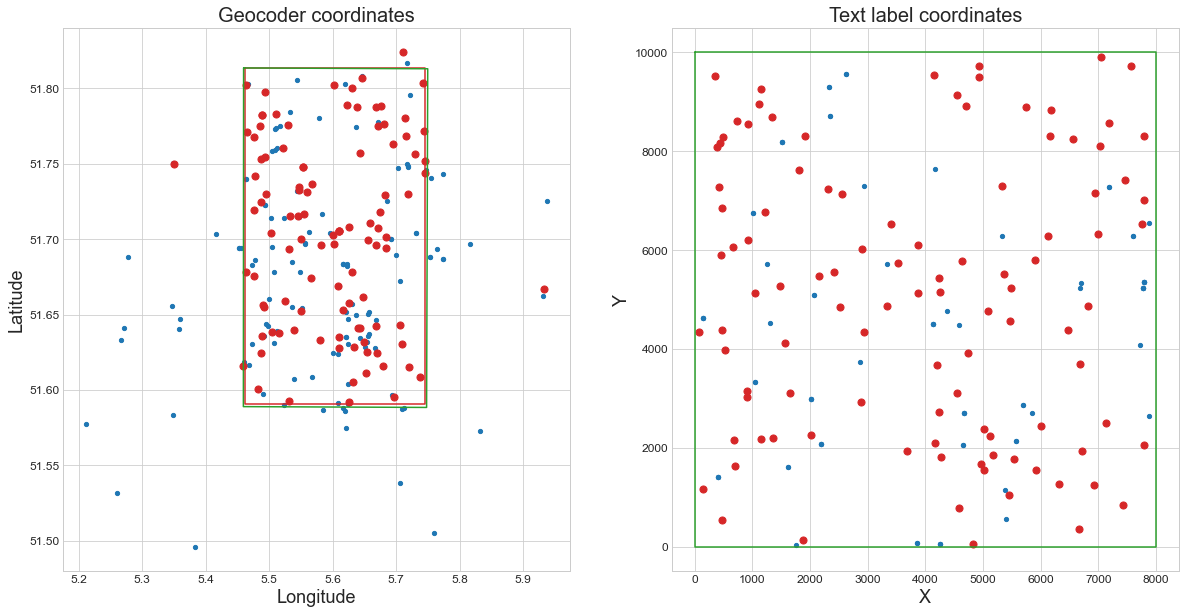

Removed id: 53 min val: -0.18665246495805476

Removed id: 0 min val: -0.1102520665499176

Removed id: 10 min val: -0.009915906869430557

Removed id: 52 min val: -0.0027333985807773686

Removed id: 24 min val: -0.0010112711642253913



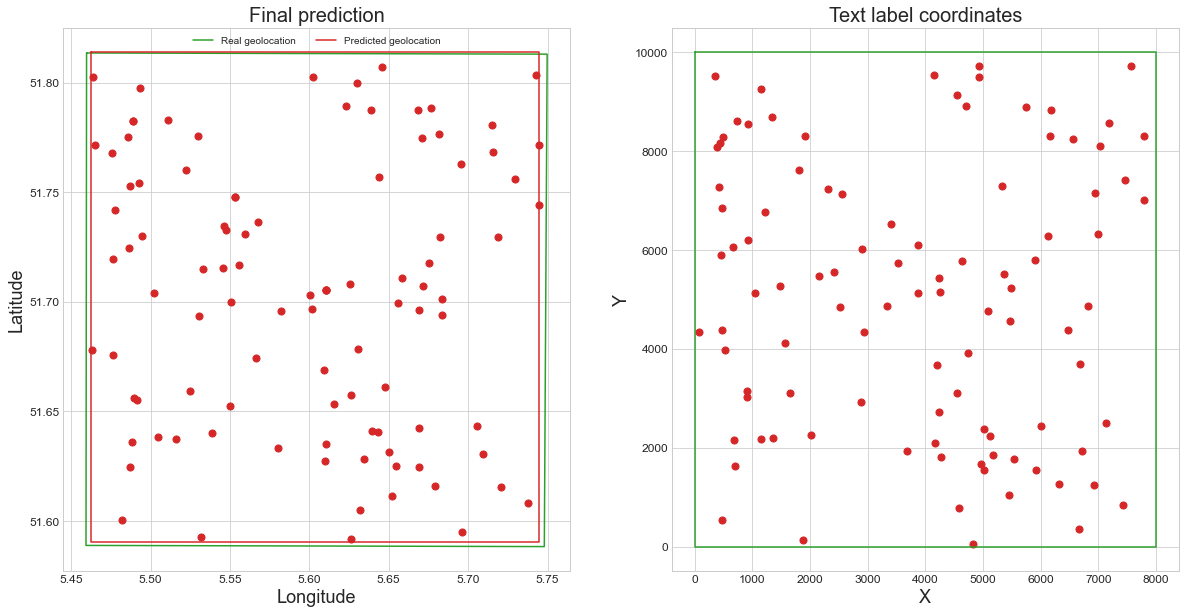


Total processing time: 47 s
[ 5.46237712 51.59055351  5.74436933 51.81385099]
Max dist of bounds: 380 m
Mean dist of bounds: 299 m
Center dist: 148 scale: 0.0046
Amount inside bounds: 0.966


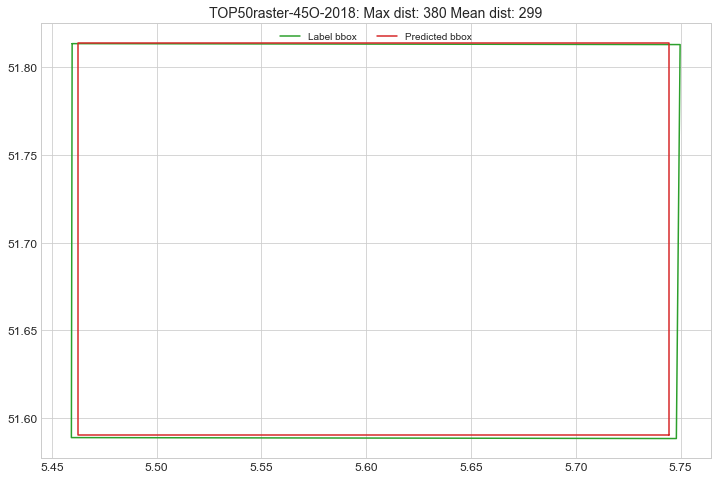


Current file: TOP50raster-45W-2018.jpg
Amount of filtered lines: 679


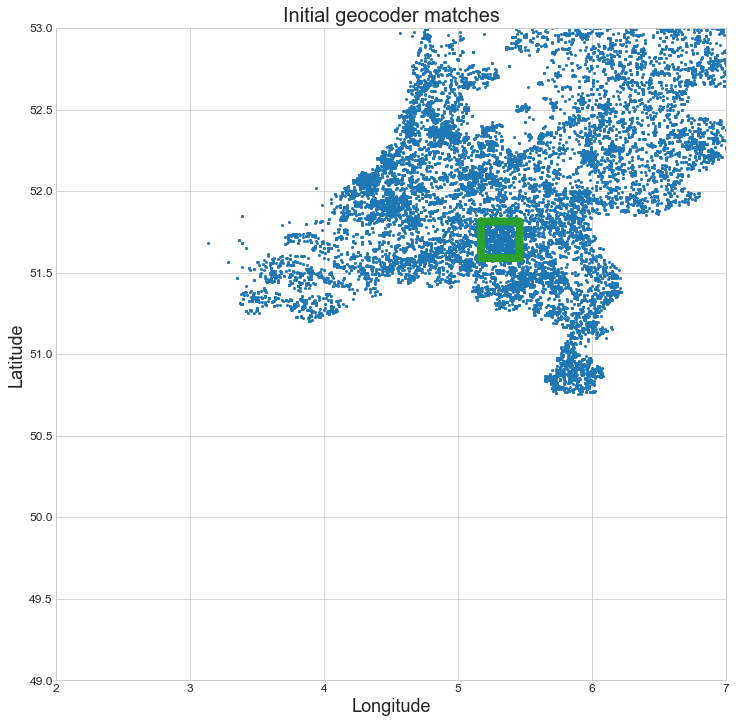

Finding initial region with best matches
len lines: 215


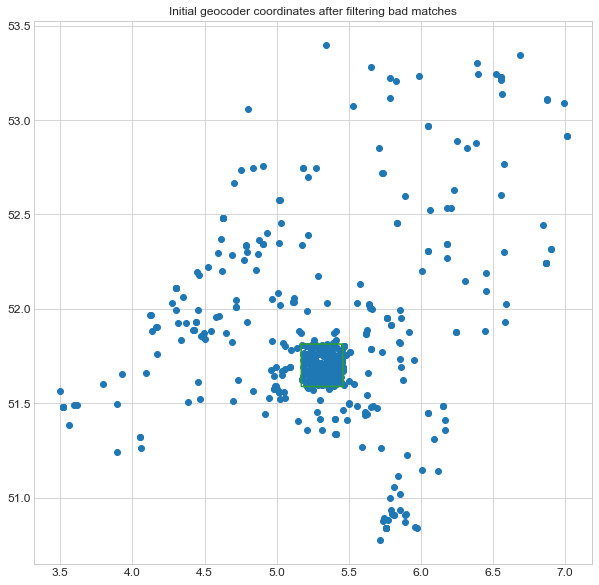


Prefilter filtered out: 1


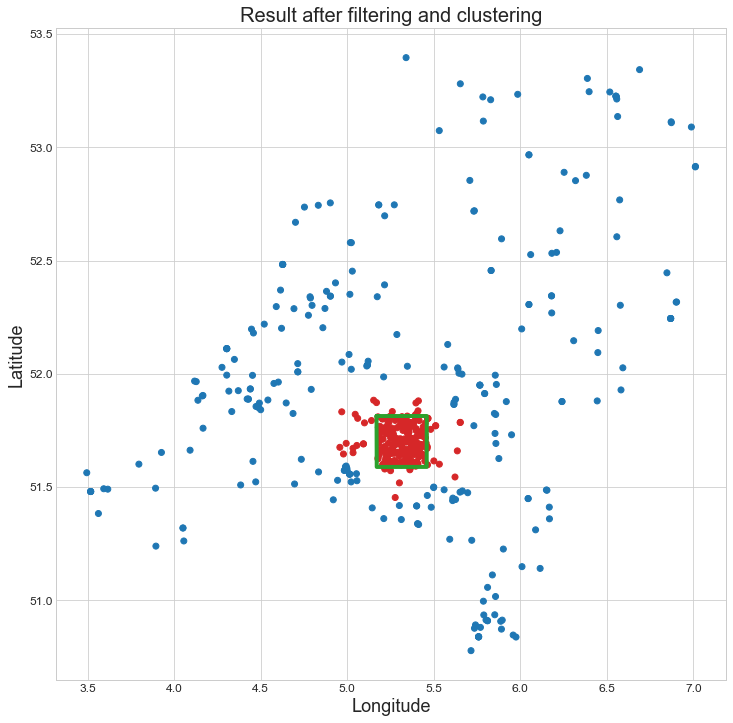

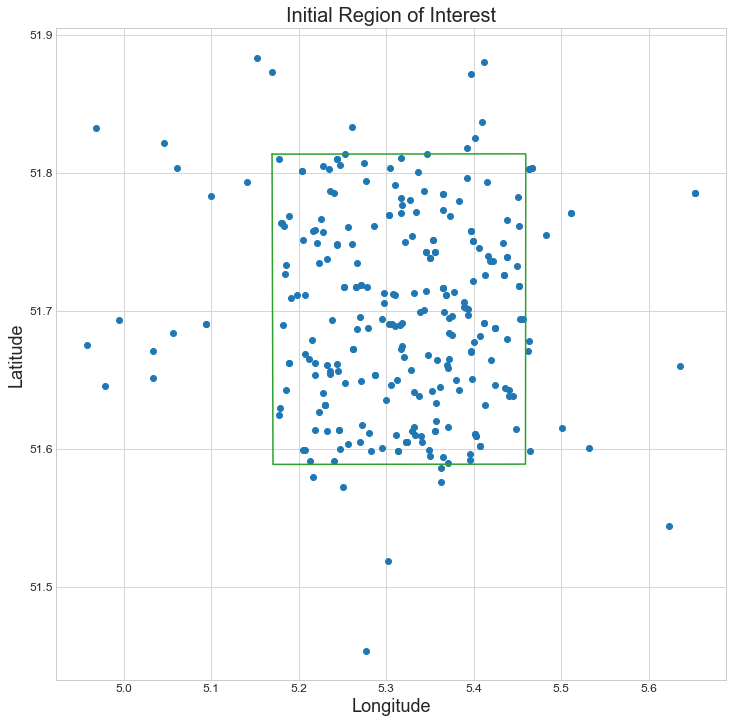

Len lines inside: 160
RANSAC: Best model error: 0.06515775034293553 number of inliers: 108
RANSAC: Average time per iteration: 0.00481 s
lng min: 5.171015158743972
lng max: 5.453781614682912
lat min: 51.58995618754255
lat max: 51.811447643957386


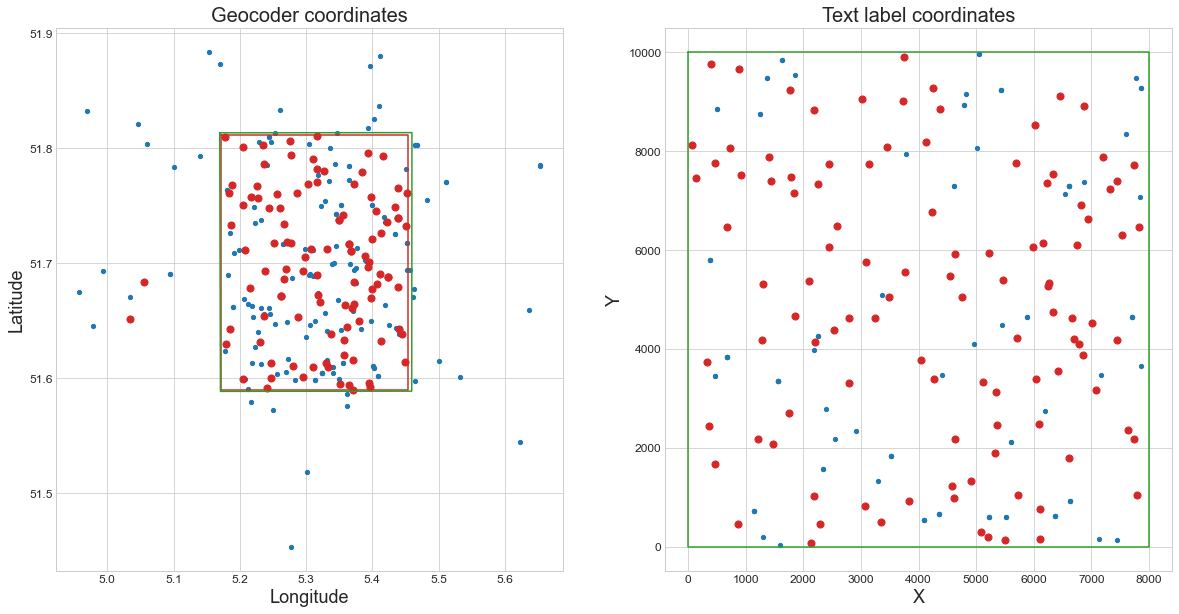

Removed id: 34 min val: -0.136935158743972

Removed id: 42 min val: -0.12024357825385312



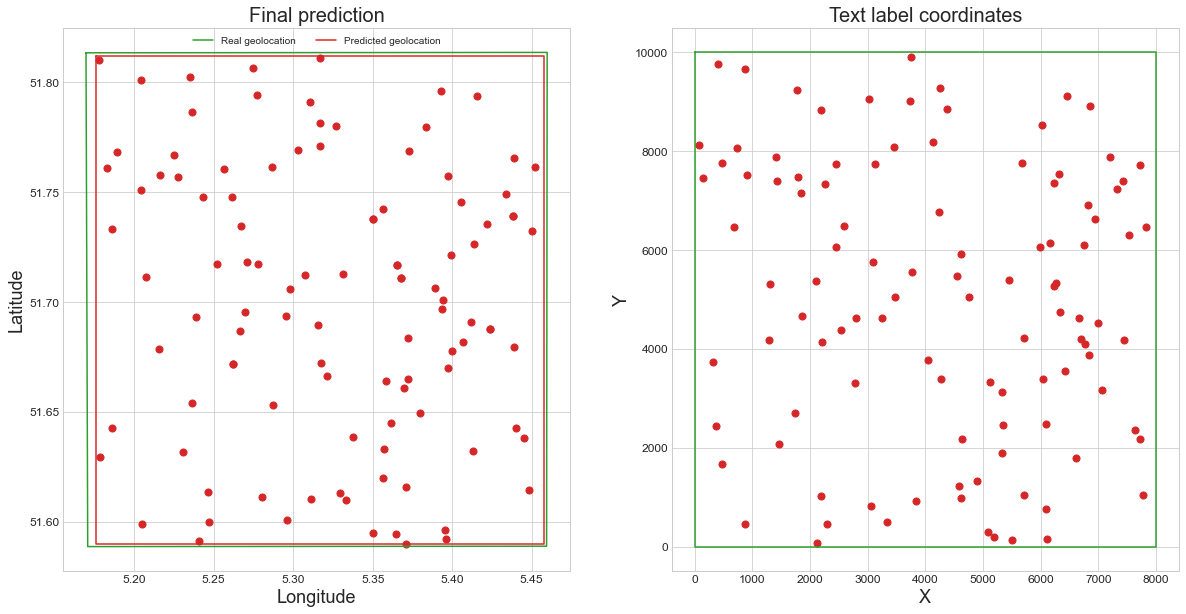


Total processing time: 54 s
[ 5.17611655 51.59005136  5.45778542 51.81181057]
Max dist of bounds: 478 m
Mean dist of bounds: 321 m
Center dist: 145 scale: 0.0045
Amount inside bounds: 0.961


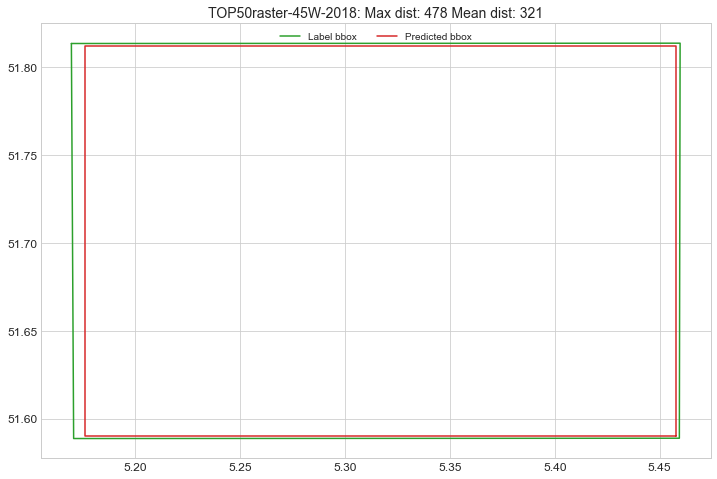

In [6]:
data_dir = 'dataset/TOP50raster'

img_dir = os.path.join(data_dir, 'cropped')
json_dir = os.path.join(data_dir, 'json')
plot_dir = os.path.join(data_dir, 'plots')
geolocation_dir = os.path.join(data_dir, 'geolocation')
n_geojson = 0
counter = 0

results = []
fnames_not_geolocated = []

save_plot = False
verbose = 1
plot = verbose
n_lines = 0
all_label_polygons = []
all_bounds = []
all_mean_dists = []
all_max_dists = []
all_n_lines = []
all_n_filtered = []
all_n_perfect = []
all_n_lines_geoloc = []
all_text = []
all_fnames = []

all_center_dists = []
diag_dists = []
all_step_bounds = []
all_label_bounds = []
for fname in os.listdir(img_dir):
    counter += 1
    if '-Copy' in fname:
        continue
    if '.jpg' not in fname:
        continue
    
    map_name = fname.replace('.jpg', '')

    t_start = time.time()

    lines_fname = os.path.join(json_dir, map_name + '_lines.json')
    geolocation_fname = os.path.join(geolocation_dir, map_name + '_geolocation.json')

    lines = json.load(open(lines_fname, 'r', encoding='utf-8'))['lines']
    try:
        map_info = json.load(open(os.path.join(json_dir, map_name + '.json'), 'r'))
    except:
        pass

    if 'TOP50' in data_dir:
        label_coords = map_info['label_coordinates_WGS84']
        label_coords = np.array(label_coords).reshape((4, 2))
    elif 'topo' in data_dir:
        label_coords = parse_coords(map_info['label_ngi'])
    else:
        label_coords = None

    print('\nCurrent file:', fname)
    geo_lines = [line for line in lines if 'geolocation' in line]
    if label_coords is not None:
        lng1 = np.min(label_coords[:, 0])
        lat1 = np.min(label_coords[:, 1])
        lng2 = np.max(label_coords[:, 0])
        lat2 = np.max(label_coords[:, 1])

        label_poly = geometry.Polygon(label_coords)

        diag_dists.append(haversine(lat1, lng1, lat2, lng2))
    else:
        label_poly = None

    text_arr = [l['text'] for l in lines if len(l['text']) > 3]
    n_l = len(text_arr)
    # Filter only those with geocoder results
    geo_lines = [l for l in lines if ('geolocation' in l and len(l['geolocation']) > 0)]

    geo_lines2 = []
    text_dict = {}
    for line in geo_lines:
        text = line['text']

        if 'www' in text:
            continue

        geo = line['geolocation']

        # If line was vertical and was recognized both ways
        # Check to see if one of the two was empty
        if 'geolocation2' in line:
            line = take_best(line)
            # If both geolocations empty
            if line is None:
                continue
        elif len(geo) == 0:
            continue

        geo_lines2.append(line)

        t = line['text'].lower()
        if t in text_dict:
            text_dict[t] += 1
        else:
            text_dict[t] = 1

    geo_lines3 = []
    for l in geo_lines2:
        t = l['text'].lower()

        if text_dict[t] > 3:
            continue
        else:
            geo_lines3.append(l)

    # Filter out if more numbers than letters
    filtered_lines = []

    for line in geo_lines3:

        if len(line['geolocation']) == 0:
            continue

        text = line['text']

        n_total = len(text)
        n_int = 0
        for char in text:
            try:
                int(char)
                n_int += 1
            except ValueError:
                pass
        if n_int < n_total // 2:
            filtered_lines.append(line)

    n_filtered_lines = len(filtered_lines)
    print('Amount of filtered lines:', n_filtered_lines)

    all_text.append(text_arr)
    all_n_lines.append(n_l)
    all_n_lines_geoloc.append(n_filtered_lines)
    all_fnames.append(fname)
    if len(filtered_lines) == 0:
        all_max_dists.append(None)
        all_mean_dists.append(None)
        continue

    all_n_filtered.append(len(filtered_lines))

    img_shape = cv2.imread(os.path.join(img_dir, fname)).shape
    n_lines += 1

    fig_fname = os.path.join(plot_dir, map_name + '_cluster.png')
    try:
        res = geolocate(filtered_lines, img_shape, filter_common=True, verbose=verbose, label_coords=label_coords,
                        figure_fname=fig_fname)
    except BaseException as e:
        print('ERROR OCCURRED DURING GEOLOCATION')
        print(e)
        print()
        continue
    t_end = time.time()
    print()
    print('Total processing time:', round(t_end - t_start), 's')
    found = False
    if res is not None:
        
        lines_possible, lines_discarded, bounds, step_bounds = res
        all_step_bounds.append(step_bounds)

        # Just use bounds right now
        bounds = np.array(bounds).reshape((2, 2))[:, ::-1].ravel()
        print(bounds)
        lng1, lat1, lng2, lat2 = bounds

        geoloc_obj = {'lng1': lng1, 'lat1': lat1, 'lng2': lng2, 'lat2': lat2}
        json.dump(geoloc_obj, open(geolocation_fname, 'w'))

        poly_bounds = geometry.box(*bounds)

        if label_coords is not None:
            mean_d, max_d = mean_dist(bounds, label_coords)
            center_d, scale = center_dist_scale(bounds, label_coords)
            all_mean_dists.append(mean_d)
            all_max_dists.append(max_d)
            all_center_dists.append(center_d)
            all_label_bounds.append(label_coords)
            print('Max dist of bounds:', round(max_d), 'm')
            print('Mean dist of bounds:', round(mean_d), 'm')
            print('Center dist:', round(center_d), 'scale:', round(scale, 4))

            # determine IOU based on bbox of track?
            label_poly = geometry.Polygon(label_coords)
            iou_bounds = iou(poly_bounds, label_poly)

            all_label_polygons.append(label_poly)
            all_bounds.append(poly_bounds)

            fraction_inside_bounds = fraction_inside(poly_bounds, label_poly.buffer(0))
            if fraction_inside_bounds is None:
                fraction_inside_bounds = 0
            print('Amount inside bounds:', round(fraction_inside_bounds, 3))
            results.append([fraction_inside_bounds, iou_bounds, -1, -1])
        found = True
        # Plotting
        if plot or save_plot:
            try:
                plt.figure(figsize=(12, 8))
                if label_coords is not None:
                    plt.plot(*label_poly.exterior.xy, color='C2', label='Label bbox')

                plt.plot(*poly_bounds.exterior.xy, color='C3', label='Predicted bbox')
                plt.legend(loc='upper center', ncol=2)
                plt.title(map_name + ': Max dist: ' + str(round(max_d)) + ' Mean dist: ' + str(round(mean_d)),
                          fontsize=14)
                # plt.title(map_name+', amount inside bounds: '+str(round(fraction_inside_bounds,3))+' IOU: '+str(round(iou_bounds,3)),
                #         fontsize=18)
                if save_plot:
                    plt.savefig(os.path.join(plot_dir, map_name + '.png'))
                if plot:
                    plt.show()
                else:
                    plt.close()
            except BaseException as e:
                print('ERROR OCCURRED DURING PLOTTING')
                print(e)
                print()

    # If this fails, accept the failure
    if not found:
        print('NOT ABLE TO GEOLOCATE MAP:', map_name)
        results.append(None)
        fnames_not_geolocated.append(map_name)
        all_max_dists.append(None)
        all_mean_dists.append(None)
        continue




In [7]:
def center_dist(c1,bounds_label):
    c1 = c1[::-1]
    c2 = np.mean(bounds_label,axis=0)[::-1]
    center_dist = haversine(*c1,*c2)
    
    return center_dist


def calculate_errors(all_step_bounds,all_label_bounds):
    """
    Max dist = largest mean error for all maps, for each step
    """
    
    best_means = []
    best_centers = []
    
    # shape (1,5), 5 steps
    mean_dists = [0]*5
    max_dists = [0]*5
    center_dists = [0]*5
    l = len(all_step_bounds)
    # for each map
    for i in range(l):
        label_b = all_label_bounds[i] 
        # for each step
        for j in range(len(all_step_bounds[i])):
            b,c = all_step_bounds[i][j]
            b = np.array(b).reshape((2,2))[:,::-1].ravel()   
            mean_d,max_d = mean_dist(b,label_b)
            center_d = center_dist(c,label_b)
            
            if j == len(all_step_bounds[i])-1:
                best_means.append(mean_d)
                best_centers.append(center_d)
            
            
            
           
            mean_dists[j] += mean_d
            
            center_dists[j] += center_d
            if max_dists[j] < mean_d:
                max_dists[j] = mean_d
    
    mean_dists = np.array(mean_dists)/l
    max_dists = np.array(max_dists)
    center_dists = np.array(center_dists)/l
    return mean_dists,max_dists,center_dists,best_means,best_centers




### Results for TOP50Raster 10K RANSAC iterations

**Note: The values change slightly for each run of the algorithm due to the randomized outlier removal of RANSAC. The results reported in the paper were the average of 3 iterations of the full algorithm.**

In [9]:
mean_d,max_d,center_d,best_means,best_centers = calculate_errors(all_step_bounds,all_label_bounds)

labels = ['No Filter','Prefilter','Initial ROI','Refined ROI','Final prediction:']

print('Means:')
for i,m in enumerate(mean_d):
    print(labels[i],round(m),'m')

print()
print('Max:')
for i,m in enumerate(max_d):
    print(labels[i],round(m),'m')
print()
print('Center:')
for i,m in enumerate(center_d):
    print(labels[i],round(m),'m')

Means:
No Filter 173560 m
Prefilter 170090 m
Initial ROI 16801 m
Refined ROI 348 m
Final prediction: 263 m

Max:
No Filter 181378 m
Prefilter 181378 m
Initial ROI 19874 m
Refined ROI 721 m
Final prediction: 385 m

Center:
No Filter 10214 m
Prefilter 10043 m
Initial ROI 1166 m
Refined ROI 256 m
Final prediction: 151 m


In [12]:
all_max_d = [d for d in all_max_dists if d is not None]
all_mean_d = [d for d in all_mean_dists if d is not None]
all_center_d = [d for d in all_center_dists if d is not None]

print('Amount of maps:',len(all_max_d),len(all_mean_d))
print('Average map diagonal:',round(np.mean(diag_dists)),'m')
print('Average/Median mean dist:',round(np.mean(all_mean_d)),'m',round(np.median(all_mean_d)),'m')
print('Average/Median center dist:',round(np.mean(all_center_d)),'m',round(np.median(all_center_d)),'m')
print('Max mean dist:',round(np.max(all_mean_d)),'m')
print('Maps that failed to geolocate:',len(fnames_not_geolocated))

Amount of maps: 9 9
Average map diagonal: 32065 m
Average/Median mean dist: 263 m 245 m
Average/Median center dist: 151 m 145 m
Max mean dist: 385 m
Maps that failed to geolocate: 0


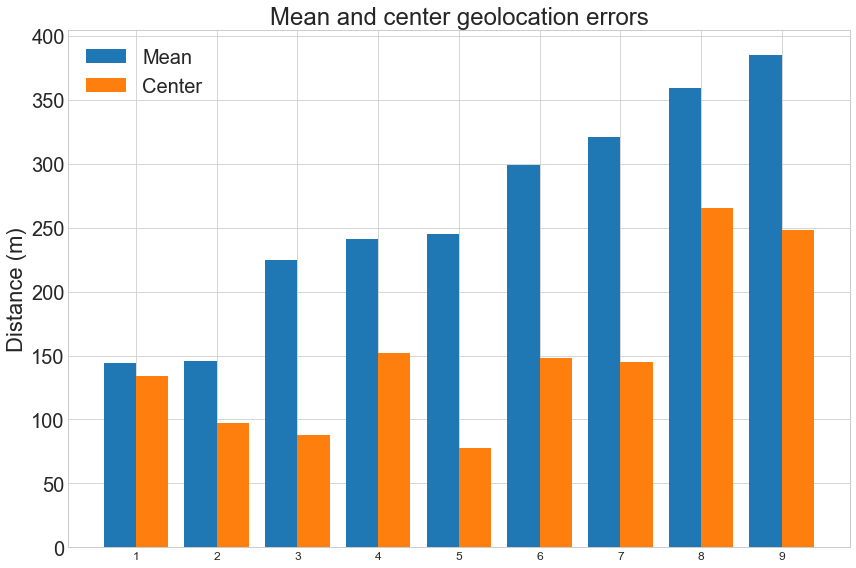

In [15]:
labels = list(map(str,[x for x in range(1,len(all_center_d)+1)]))
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
fig, ax = plt.subplots(figsize=(12,8))

cent_d = np.round(all_center_d)
mean_d = np.round(all_mean_d)

indices = np.argsort(mean_d)
cent_d = cent_d[indices]
mean_d = mean_d[indices]

rects1 = ax.bar(x - width/2, mean_d, width, label='Mean')
rects2 = ax.bar(x + width/2, cent_d, width, label='Center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distance (m)',fontsize=22)
ax.set_title('Mean and center geolocation errors',fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.axis('tight')
plt.tick_params(axis='both', which='minor', labelsize='large')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


fig.tight_layout()
plt.show()

### All ground truth bounds (dotted) + predictions for TOP50raster dataset

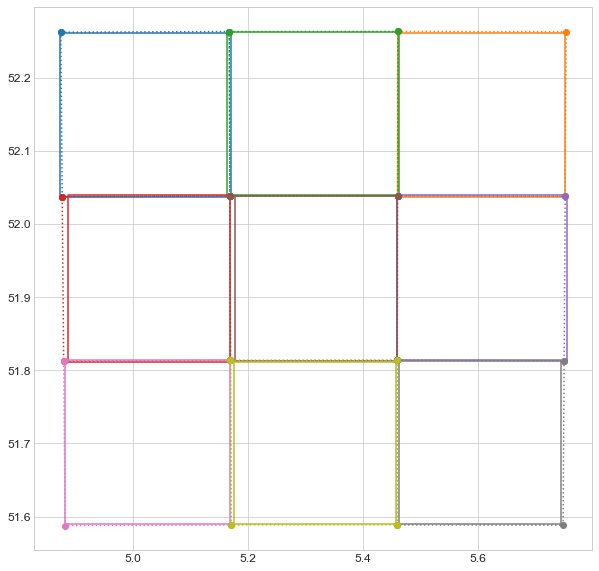

In [16]:
plt.figure(figsize=(10,10))

for i in range(len(all_label_polygons)):
    color = 'C'+str(i%10)
    plt.plot(*all_label_polygons[i].exterior.xy,'o:',color=color)
    #plt.plot(*poly_label_bbox.exterior.xy,'--k',color='green')
    plt.plot(*all_bounds[i].exterior.xy,color=color)
    
    
plt.show()